# Import library


In [2]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import numpy as np
from datetime import datetime
from datetime import date
import re
from sklearn.cluster import KMeans
from itertools import combinations
from collections import Counter

In [3]:
def detect_outliers_iqr(df: pl.LazyFrame, column: str):
    is_lazy = isinstance(df, pl.LazyFrame)
    if is_lazy:
        quantiles = (
            df.select([
                pl.col(column).quantile(0.25).alias("Q1"),
                pl.col(column).quantile(0.75).alias("Q3")
            ])
            .collect()
        )
    else:
        quantiles = df.select([
            pl.col(column).quantile(0.25).alias("Q1"),
            pl.col(column).quantile(0.75).alias("Q3")
        ])

    Q1 = quantiles["Q1"][0]
    Q3 = quantiles["Q3"][0]
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    if is_lazy:
        outlier_count = (
            df.filter((pl.col(column) < lower) | (pl.col(column) > upper))
            .select(pl.count().alias("outlier_count"))
            .collect()["outlier_count"][0]
        )
    else:
        outlier_count = (
            df.filter((pl.col(column) < lower) | (pl.col(column) > upper))
            .select(pl.len().alias("outlier_count"))["outlier_count"][0]
        )

    print(f"Outlier count for '{column}': {outlier_count:,}")

def lazy_null_summary(df: pl.LazyFrame | pl.DataFrame):
    if isinstance(df, pl.LazyFrame):
        null_counts = df.select([
            pl.col(c).null_count().alias(c) for c in df.collect_schema().names()
        ]).collect()
        total_rows = df.select(pl.len()).collect().item()
    else:
        null_counts = df.null_count()
        total_rows = df.height
    return (
        null_counts.transpose(
            include_header=True,
            header_name="column",
            column_names=["null_count"]
        )
        .with_columns([
            (pl.col("null_count") / total_rows * 100).alias("null_percent")
        ])
        .sort("null_percent", descending=True)
    )


# Phân tích dữ liệu

## Item chunk Dataset

In [4]:
files = glob.glob("data_full/sales_item/*.parquet")
item_chunk_df = pl.concat([pl.read_parquet(f) for f in files])

In [5]:
item_chunk_df.head()

p_id,item_id,price,category_l1_id,category_l1,category_l2_id,category_l2,category_l3_id,category_l3,category_id,category,description,brand,manufacturer,creation_timestamp,is_deleted,created_date,updated_date,sync_status_id,last_sync_date,sync_error_message,image_url,gender_target,age_group,item_type,gp,weight,color,size,origin,volume,material,sale_status,description_new
i32,str,"decimal[38,4]",i32,str,i32,str,i32,str,i32,str,str,str,str,i64,bool,datetime[μs],datetime[μs],i32,datetime[μs],str,str,str,str,str,"decimal[38,4]",f32,str,str,str,str,str,i32,str
17065,"""0502020000004""",99000.0000,1,"""Babycare""",35,"""Bình sữa, phụ kiện""",7050,"""Núm ty""",7058,"""Núm ty Dr Brown""","""Không xác định""","""Dr.Brown's""","""Không xác định""",1333531544,false,2012-04-04 09:25:44.240,2025-08-18 09:59:19.847,2,2025-07-18 17:59:29.898256,null,"""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""",36828.0000,null,"""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""",0,"""Chi tiết sản phẩm …"
72370,"""0010290040150""",69000.0000,3292,"""Thời trang""",3958,"""Cơ cấu hàng cũ""",7007,"""Thời trang bé trai, bé gái cũ""",6987,"""Bộ quần áo bé gái""","""Không xác định""","""Con Cưng""","""Không xác định""",1503046250,false,2017-08-18 08:50:50.713,2025-09-18 16:05:42.360,null,null,null,"""Không xác định""","""Bé Gái""","""Từ 3Y""","""Bộ quần áo""",0.0000,null,"""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""",0,"""Không xác định"""
31154,"""0008010000015""",45000.0000,351,"""Đồ chơi & Sách""",2033,"""0-1Y""",2118,"""Gặm nướu""",2121,"""Gặm nướu khác""","""- Chất liệu: Sản phẩm được làm…","""Thương hiệu khác""","""Không xác định""",1358501584,false,2013-01-18 09:33:04.260,2025-09-27 00:05:36.233,2,2025-07-18 17:59:29.898256,null,"""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""",14490.0000,null,"""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""",0,"""Chi tiết sản phẩm …"
46123,"""0020010000094""",401000.0000,2222,"""Tã""",2272,"""Merries""",2275,"""Merries""",2276,"""Merries_Sơ Sinh""","""﻿﻿Tã dán Merries size S 82 miế…","""Merries Nhật""","""Không xác định""",1400062039,false,2014-05-14 10:07:19.603,2025-09-27 00:05:36.233,2,2025-07-18 17:59:29.898256,null,"""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""",59749.0000,null,"""Không xác định""","""Không xác định""","""Nhật Bản, Nhật Bản""","""Không xác định""","""Giấy, bột giấy, vải không dệt,…",0,"""Không xác định"""
46127,"""0020010000098""",401000.0000,2222,"""Tã""",2272,"""Merries""",2275,"""Merries""",2278,"""Merries_Tã Quần""","""﻿﻿﻿Bỉm tã quần Merries size M …","""Merries Nhật""","""Không xác định""",1400062040,false,2014-05-14 10:07:20.370,2025-09-27 00:05:36.233,2,2025-07-18 17:59:29.898256,null,"""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""",65764.0000,null,"""Không xác định""","""Không xác định""","""Nhật Bản, Nhật Bản""","""Không xác định""","""Giấy, bột giấy, vải không dệt,…",0,"""Không xác định"""


In [4]:
print(f"Kích thước: {item_chunk_df.height:,} dòng × {len(item_chunk_df.columns)} cột")
print("Schema:")
schemas=item_chunk_df.schema
for name, dtype in schemas.items():
    print(f"{name}: {dtype}")

print(item_chunk_df.describe())

lazy_null_summary(item_chunk_df)

Kích thước: 27,332 dòng × 34 cột
Schema:
p_id: Int32
item_id: String
price: Decimal(precision=38, scale=4)
category_l1_id: Int32
category_l1: String
category_l2_id: Int32
category_l2: String
category_l3_id: Int32
category_l3: String
category_id: Int32
category: String
description: String
brand: String
manufacturer: String
creation_timestamp: Int64
is_deleted: Boolean
created_date: Datetime(time_unit='us', time_zone=None)
updated_date: Datetime(time_unit='us', time_zone=None)
sync_status_id: Int32
last_sync_date: Datetime(time_unit='us', time_zone=None)
sync_error_message: String
image_url: String
gender_target: String
age_group: String
item_type: String
gp: Decimal(precision=38, scale=4)
weight: Float32
color: String
size: String
origin: String
volume: String
material: String
sale_status: Int32
description_new: String
shape: (9, 35)
┌────────────┬──────────────┬──────────────┬──────────────┬───┬──────────────┬─────────────┬─────────────┬─────────────┐
│ statistic  ┆ p_id         ┆ item

column,null_count,null_percent
str,u32,f64
"""sync_error_message""",27332,100.0
"""weight""",27332,100.0
"""description_new""",5015,18.348456
"""sync_status_id""",786,2.87575
"""last_sync_date""",786,2.87575
…,…,…
"""size""",0,0.0
"""origin""",0,0.0
"""volume""",0,0.0


In [5]:
unique_counts = item_chunk_df.select([
    pl.col(col).n_unique().alias(f"{col}") for col in item_chunk_df.columns
])
unique_counts = unique_counts.transpose(include_header=True, header_name="column", column_names=["n_unique"])
print(unique_counts)
low_info_cols = unique_counts.filter(pl.col("n_unique") <= 5)
print(low_info_cols)


shape: (34, 2)
┌─────────────────┬──────────┐
│ column          ┆ n_unique │
│ ---             ┆ ---      │
│ str             ┆ u32      │
╞═════════════════╪══════════╡
│ p_id            ┆ 27332    │
│ item_id         ┆ 27332    │
│ price           ┆ 733      │
│ category_l1_id  ┆ 15       │
│ category_l1     ┆ 15       │
│ …               ┆ …        │
│ origin          ┆ 293      │
│ volume          ┆ 138      │
│ material        ┆ 583      │
│ sale_status     ┆ 2        │
│ description_new ┆ 9502     │
└─────────────────┴──────────┘
shape: (8, 2)
┌────────────────────┬──────────┐
│ column             ┆ n_unique │
│ ---                ┆ ---      │
│ str                ┆ u32      │
╞════════════════════╪══════════╡
│ is_deleted         ┆ 1        │
│ sync_status_id     ┆ 2        │
│ last_sync_date     ┆ 4        │
│ sync_error_message ┆ 1        │
│ image_url          ┆ 1        │
│ gender_target      ┆ 5        │
│ weight             ┆ 1        │
│ sale_status        ┆ 2        │
└─

In [6]:
df = pl.DataFrame({
    "sync_status_id": item_chunk_df["sync_status_id"],
    "sale_status": item_chunk_df["sale_status"],
    "gender target": item_chunk_df["gender_target"],
    "last_sync_date": item_chunk_df["last_sync_date"]
})

for col in df.columns:
    print(f"Unique values in '{col}': {df[col].unique().to_list()}")

Unique values in 'sync_status_id': [None, 2]
Unique values in 'sale_status': [0, 1]
Unique values in 'gender target': ['Không xác định', 'Bé Trai', 'Unisex', 'Sơ sinh', 'Bé Gái']
Unique values in 'last_sync_date': [None, datetime.datetime(2025, 7, 18, 17, 59, 29, 898256), datetime.datetime(2025, 7, 20, 10, 59, 6, 647693), datetime.datetime(2025, 7, 21, 10, 59, 4, 45058)]


In [7]:
numeric_cols = [col for col, dtype in item_chunk_df.schema.items()
                if dtype in [pl.Decimal]
                and col not in ["creation_timestamp"]]

item_chunk_df.select(numeric_cols).describe()


statistic,price,gp
str,f64,f64
"""count""",27332.0,27332.0
"""null_count""",0.0,0.0
"""mean""",190456.829467,49696.651226
"""std""",511123.971813,144155.68753
"""min""",0.0,0.0
"""25%""",49000.0,0.0
"""50%""",119000.0,25047.0
"""75%""",199000.0,65532.0
"""max""",2.099e7,5.54136e6


In [8]:
detect_outliers_iqr(item_chunk_df, "price")
detect_outliers_iqr(item_chunk_df, "gp")

Outlier count for 'price': 1,328
Outlier count for 'gp': 827


In [9]:
numeric_cols = ["price", "gp"]

for col in numeric_cols:
    skew_val = (
        item_chunk_df
        .select(pl.col(col).skew().alias("skew"))
        ["skew"][0]
    )
    print(f"{col} skewness: {skew_val:.2f}")



price skewness: 17.21
gp skewness: 16.96


Mean: 190456.8294672911
Median: 119000.0
Std: 511123.9718129066
Skewness: 17.20733536217327


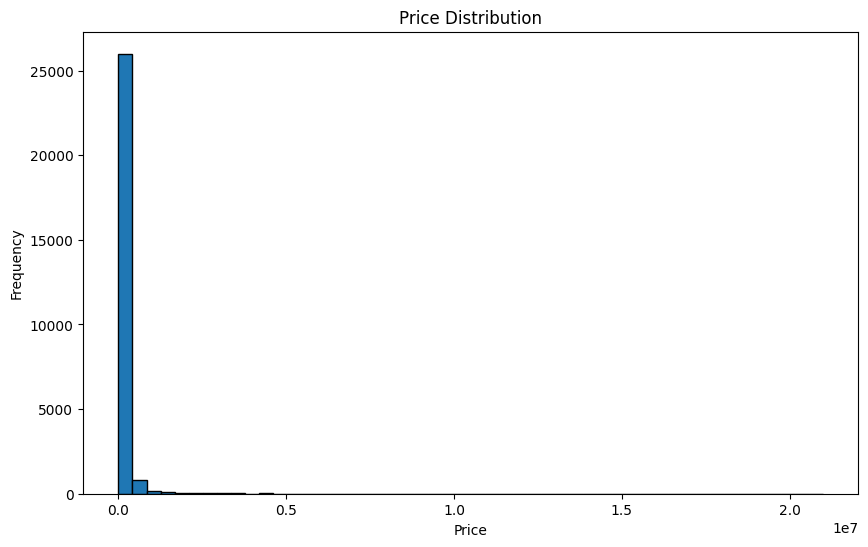

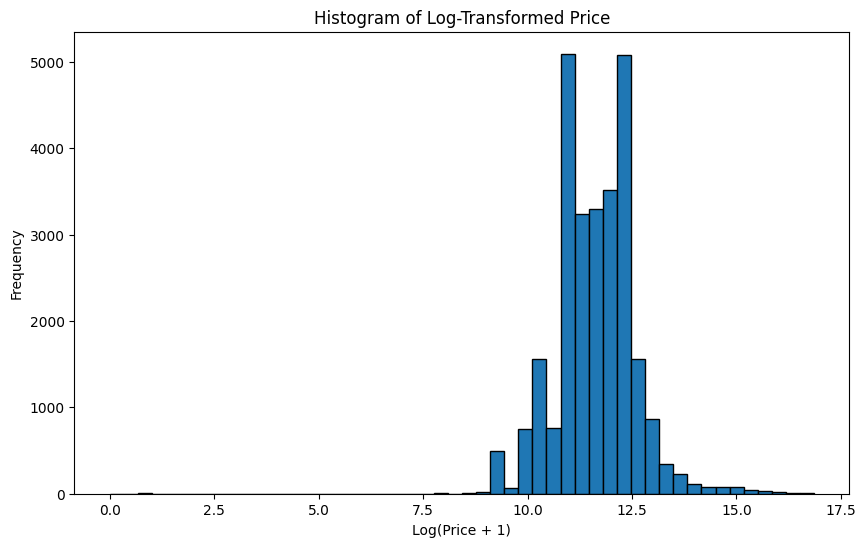

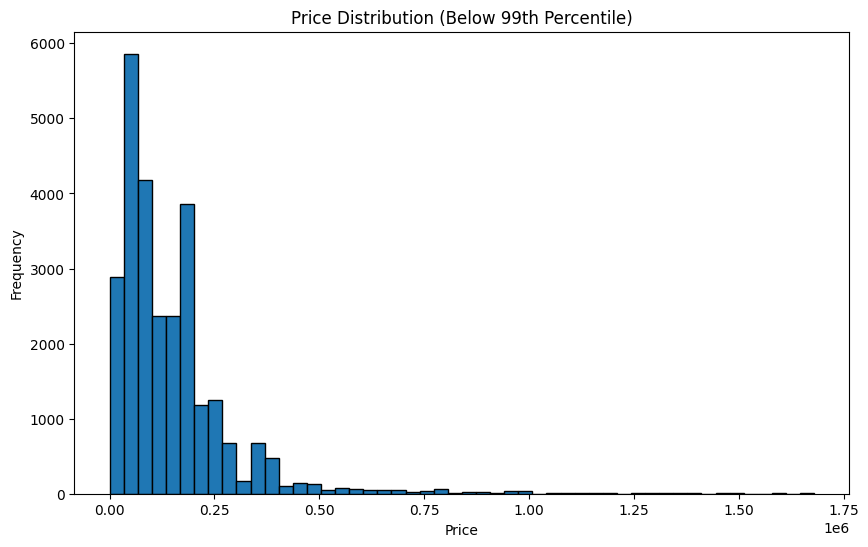

 Các giá trị Price cao hơn hoặc bằng 99th percentile:
shape: (274, 3)
┌───────────────┬──────────────────────────────┬───────────────┐
│ item_id       ┆ category                     ┆ price         │
│ ---           ┆ ---                          ┆ ---           │
│ str           ┆ str                          ┆ decimal[38,4] │
╞═══════════════╪══════════════════════════════╪═══════════════╡
│ 5956000000001 ┆ Xe đẩy Combi                 ┆ 20990000.0000 │
│ 0151000000022 ┆ Xe đẩy Combi                 ┆ 20090000.0000 │
│ 0151000000021 ┆ Xe đẩy Combi                 ┆ 17490000.0000 │
│ 5956000000002 ┆ Xe đẩy Combi                 ┆ 17490000.0000 │
│ 0148000000005 ┆ Xe đẩy Evenflo               ┆ 15590000.0000 │
│ …             ┆ …                            ┆ …             │
│ 6003000000025 ┆ Máy hâm sữa, tiệt trùng Fatz ┆ 1694000.0000  │
│ 2134000000012 ┆ Thảm nằm chơi vải            ┆ 1690000.0000  │
│ 3798000000003 ┆ Gối chống trào ngược TH khác ┆ 1690000.0000  │
│ 4289000000011 ┆ Xe

In [36]:
price = item_chunk_df["price"].cast(pl.Float64)

print("Mean:", price.mean())
print("Median:", price.median())
print("Std:", price.std())
print("Skewness:", price.skew())

plt.figure(figsize=(10,6))
plt.hist(price.drop_nulls().to_numpy(), bins=50,edgecolor='black')
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

log_price = np.log1p(price)

plt.figure(figsize=(10,6))
plt.hist(log_price, bins=50,edgecolor='black')
plt.xlabel("Log(Price + 1)")
plt.ylabel("Frequency")
plt.title("Histogram of Log-Transformed Price")
plt.show()

p99 = item_chunk_df["price"].quantile(0.99)
filtered = item_chunk_df.filter(pl.col("price") < p99)

plt.figure(figsize=(10, 6))
plt.hist(filtered["price"].to_numpy(), bins=50,edgecolor='black')
plt.title("Price Distribution (Below 99th Percentile)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

high_prices = item_chunk_df.filter(pl.col("price") >= p99)
print(" Các giá trị Price cao hơn hoặc bằng 99th percentile:")
print(high_prices.select("item_id","category", "price").sort("price", descending=True))


Mean: 49696.65122597322
Median: 25047.0
Std: 144155.6875304591
Skewness: 16.959302253095696


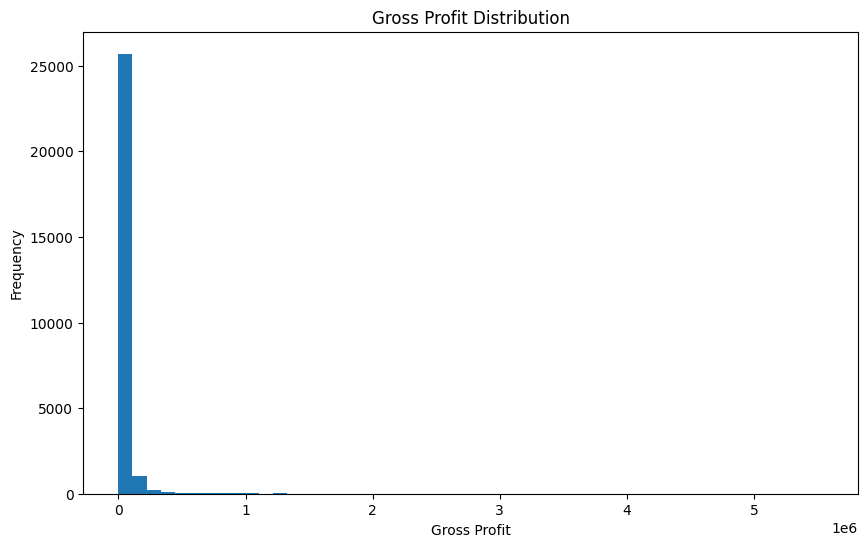

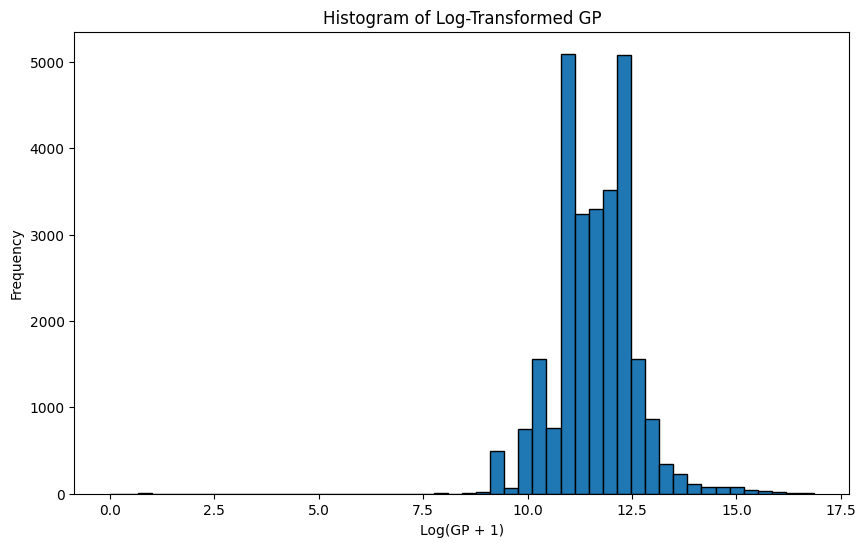

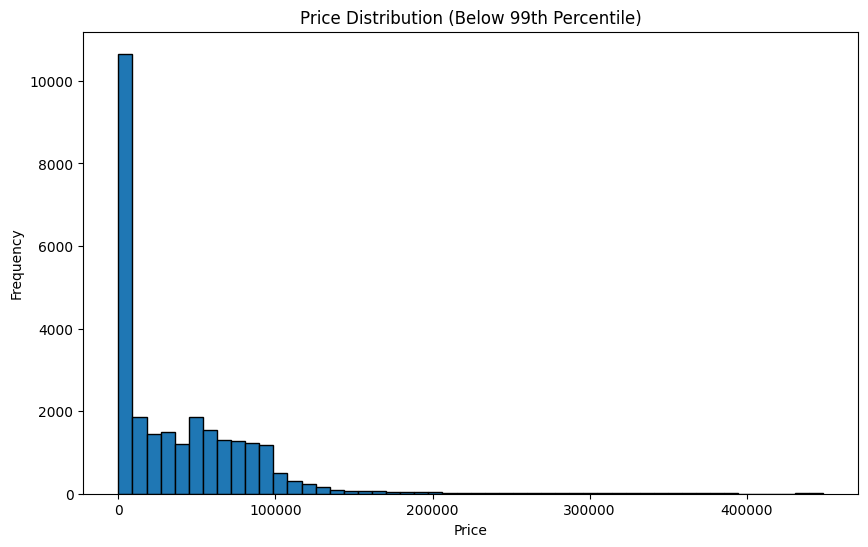

 Các giá trị Price cao hơn hoặc bằng 99th percentile:
shape: (274, 3)
┌───────────────┬──────────────────────────────┬───────────────┐
│ item_id       ┆ category                     ┆ gp            │
│ ---           ┆ ---                          ┆ ---           │
│ str           ┆ str                          ┆ decimal[38,4] │
╞═══════════════╪══════════════════════════════╪═══════════════╡
│ 5956000000001 ┆ Xe đẩy Combi                 ┆ 5541360.0000  │
│ 0151000000022 ┆ Xe đẩy Combi                 ┆ 5183220.0000  │
│ 0148000000005 ┆ Xe đẩy Evenflo               ┆ 5133790.0000  │
│ 0151000000021 ┆ Xe đẩy Combi                 ┆ 4792260.0000  │
│ 5959000000003 ┆ Xe đẩy Kinderkraft           ┆ 4208470.0000  │
│ …             ┆ …                            ┆ …             │
│ 0159000000012 ┆ Địu vải Kinderkraft          ┆ 455920.0000   │
│ 0098000000003 ┆ Xe nhún Autoru               ┆ 453390.0000   │
│ 3798000000004 ┆ Gối chống trào ngược TH khác ┆ 453250.0000   │
│ 2103000000027 ┆ Sc

In [15]:
gp = item_chunk_df["gp"].cast(pl.Float64)

print("Mean:", gp.mean())
print("Median:", gp.median())
print("Std:", gp.std())
print("Skewness:", gp.skew())

plt.figure(figsize=(10,6))
plt.hist(gp.drop_nulls().to_numpy(), bins=50)
plt.title("Gross Profit Distribution")
plt.xlabel("Gross Profit")
plt.ylabel("Frequency")
plt.show()

log_gp = np.log1p(gp)

plt.figure(figsize=(10,6))
plt.hist(log_price, bins=50,edgecolor='black')
plt.xlabel("Log(GP + 1)")
plt.ylabel("Frequency")
plt.title("Histogram of Log-Transformed GP")
plt.show()

p99 = item_chunk_df["gp"].quantile(0.99)
filtered = item_chunk_df.filter(pl.col("gp") < p99)

plt.figure(figsize=(10, 6))
plt.hist(filtered["gp"].to_numpy(), bins=50,edgecolor='black')
plt.title("Price Distribution (Below 99th Percentile)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

high_prices = item_chunk_df.filter(pl.col("gp") >= p99)
print(" Các giá trị Price cao hơn hoặc bằng 99th percentile:")
print(high_prices.select("item_id","category", "gp").sort("gp", descending=True))

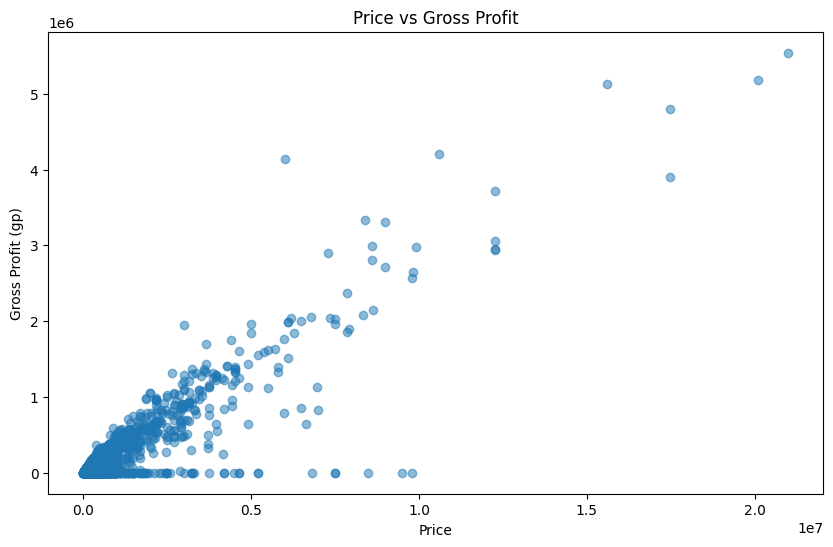

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(item_chunk_df["price"], item_chunk_df["gp"], alpha=0.5)
plt.title("Price vs Gross Profit")
plt.xlabel("Price")
plt.ylabel("Gross Profit (gp)")
plt.show()


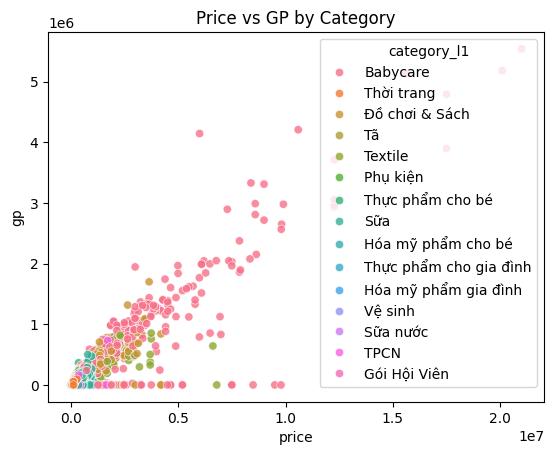

In [ ]:
df = item_chunk_df.select([pl.col("price").cast(pl.Float64),
                           pl.col("gp").cast(pl.Float64),
                           "category_l1"]).to_pandas()

sns.scatterplot(x="price", y="gp", hue="category_l1", data=df, alpha=0.8)
plt.title("Price vs GP by Category")
plt.show()


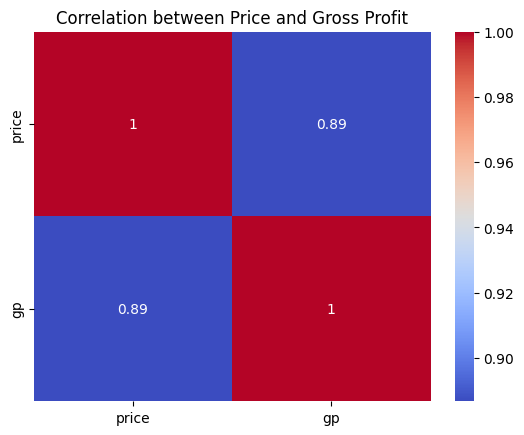

In [ ]:
df = item_chunk_df.select([
    pl.col("price").cast(pl.Float64)
, pl.col("gp").cast(pl.Float64) ]).to_pandas()

corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation between Price and Gross Profit")
plt.show()

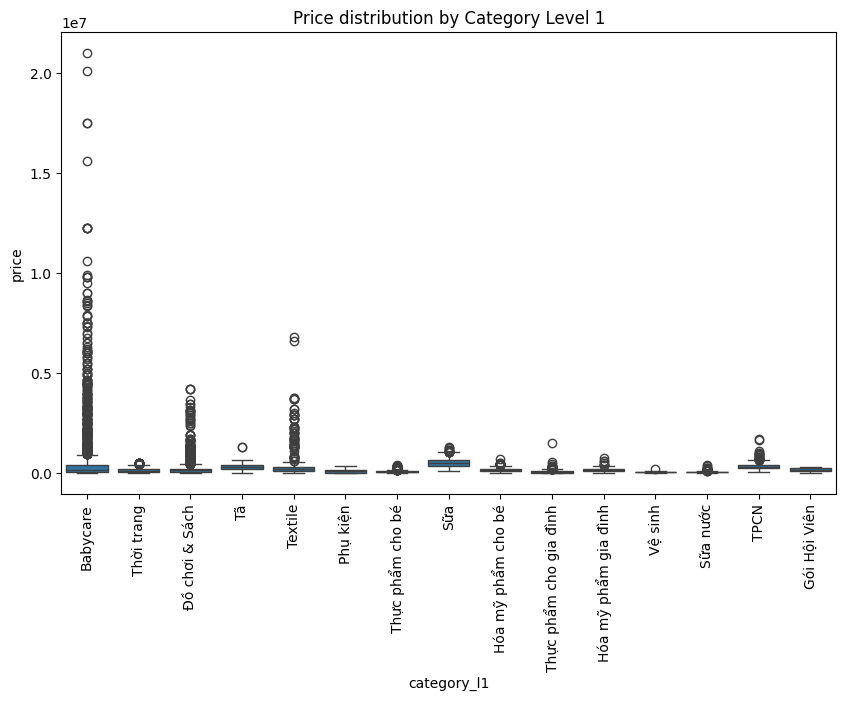

In [ ]:
df = item_chunk_df.select([
    pl.col("category_l1"),
    pl.col("price").cast(pl.Float64)
]).to_pandas()

plt.figure(figsize=(10,6))
sns.boxplot(x="category_l1", y="price", data=df)
plt.xticks(rotation=90)
plt.title("Price distribution by Category Level 1")
plt.show()


sale_status                 0     1
category_l1                        
Babycare                 1595   399
Gói Hội Viên                0     7
Hóa mỹ phẩm cho bé        209   137
Hóa mỹ phẩm gia đình      366    22
Phụ kiện                 2481   666
Sữa                       230   207
Sữa nước                   74    92
TPCN                      168   102
Textile                   475    80
Thời trang              13290  1752
Thực phẩm cho bé          474   507
Thực phẩm cho gia đình    344   126
Tã                        332   110
Vệ sinh                    80    52
Đồ chơi & Sách           2644   311


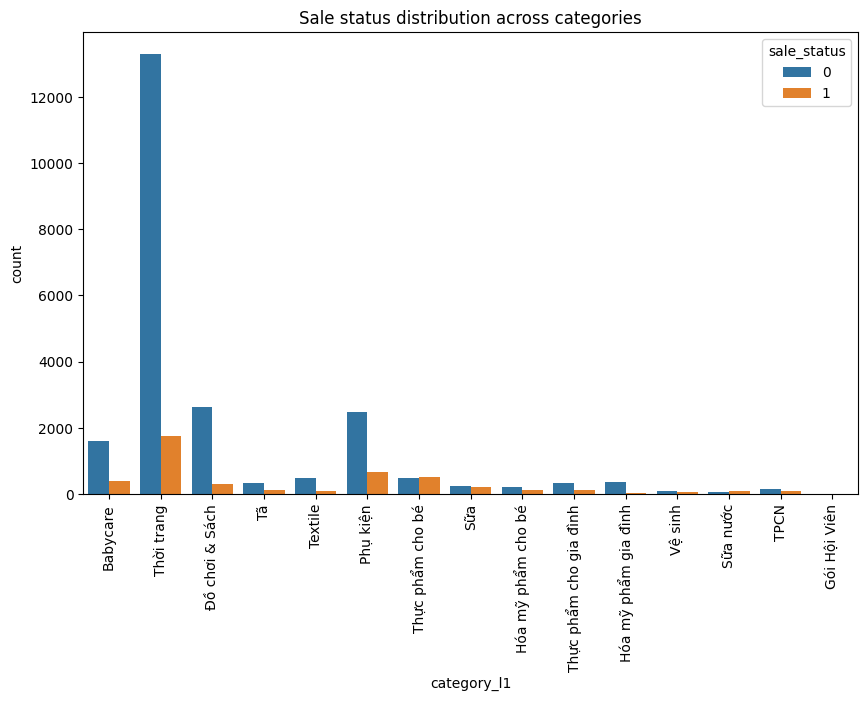

In [17]:
df = item_chunk_df.select(["category_l1", "sale_status"]).to_pandas()

ct = pd.crosstab(df["category_l1"], df["sale_status"])
print(ct)

plt.figure(figsize=(10,6))
sns.countplot(x="category_l1", hue="sale_status", data=df)
plt.xticks(rotation=90)
plt.title("Sale status distribution across categories")
plt.show()


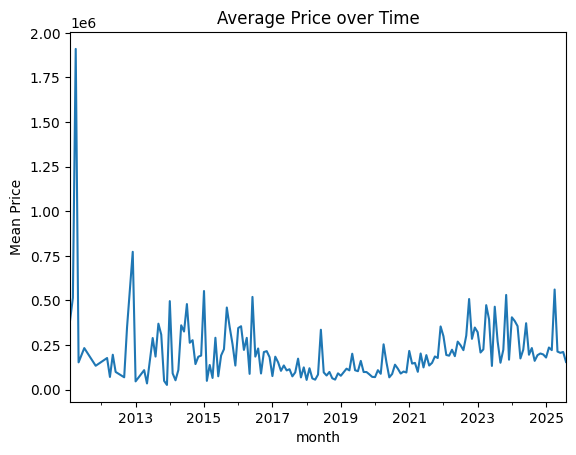

In [ ]:
df = item_chunk_df.select(["created_date", pl.col("price").cast(pl.Float64) ]).to_pandas()
df["created_date"] = pd.to_datetime(df["created_date"])

df["month"] = df["created_date"].dt.to_period("M")
trend = df.groupby("month")["price"].mean()

trend.plot(kind="line")
plt.title("Average Price over Time")
plt.ylabel("Mean Price")
plt.show()


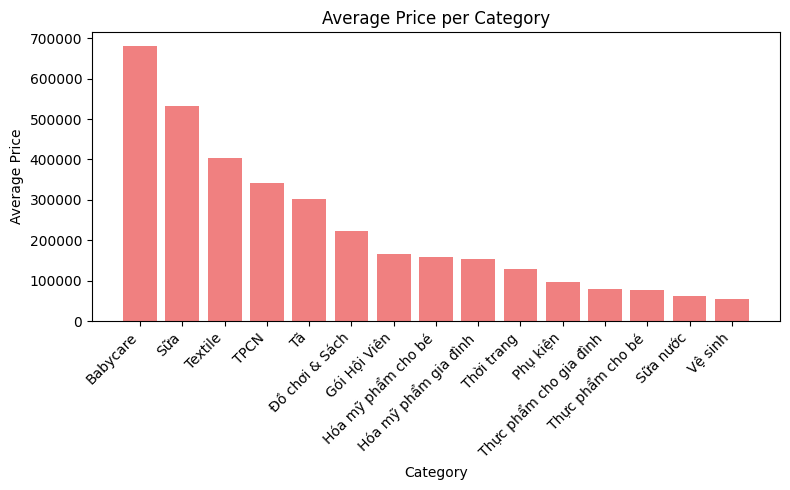

In [ ]:
df_mean = (
    item_chunk_df
    .with_columns(pl.col("price").cast(pl.Float64))
    .group_by("category_l1")
    .agg(pl.col("price").mean().alias("average_price"))
    .sort("average_price", descending=True)
)

plt.figure(figsize=(8, 5))
plt.bar(df_mean["category_l1"].to_list(), df_mean["average_price"].to_list(), color="lightcoral")
plt.title("Average Price per Category")
plt.xlabel("Category")
plt.ylabel("Average Price")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Purchase History Dataset

In [6]:
files = glob.glob("data_full/sales_history/*.parquet")
purchase_history_df = pl.concat([pl.scan_parquet(f) for f in files])

In [7]:
purchase_history_df.head().collect()

timestamp,user_id,item_id,event_type,event_value,price,date_key,quantity,customer_id,created_date,updated_date,channel,payment,location,discount,is_deleted
i64,str,str,str,"decimal[38,4]","decimal[38,4]",i32,i32,i32,datetime[μs],datetime[μs],str,str,i32,"decimal[38,4]",bool
1735064221,"""ca12702ddf55acaa9fb767e10faaa6…","""7115000000004""","""Purchase""",1.0000,49000.0000,20241224,1,5254214,2024-12-24 18:17:01.027,2024-12-24 18:20:09.453,"""In-Store""","""VietQR""",656,0.0000,false
1735068481,"""54314ce86269f4849f9a4c3fc85d94…","""0029130000030""","""Purchase""",1.0000,69000.0000,20241224,1,7573232,2024-12-24 19:28:01.870,2024-12-24 19:28:01.870,"""In-Store""","""Tiền mặt""",143,0.0000,false
1735069843,"""4799de4022b58689b2b9fb37122479…","""3496000000053""","""Purchase""",2.0000,75000.0000,20241224,2,8187418,2024-12-24 19:50:43.760,2024-12-24 19:50:43.760,"""In-Store""","""MoMo""",213,0.0000,false
1735069779,"""4799de4022b58689b2b9fb37122479…","""2700000000002""","""Purchase""",2.0000,58500.0000,20241224,2,8187418,2024-12-24 19:49:39.223,2024-12-24 19:49:39.223,"""In-Store""","""MoMo""",213,13000.0000,false
1735379373,"""3b2423f730815273dfd6f6220b0c5c…","""0029110000036""","""Purchase""",1.0000,89000.0000,20241228,1,6931560,2024-12-28 09:49:33.780,2024-12-28 10:28:49.413,"""Android""","""MoMo""",590,10000.0000,false


In [20]:
row_count = purchase_history_df.select(pl.len()).collect().item()
col_count = len(purchase_history_df.collect_schema().names())
print(f"Kích thước: {row_count:,} dòng × {col_count} cột")

print("Schema:")
for name, dtype in purchase_history_df.schema.items():
    print(f"{name}: {dtype}")

print(purchase_history_df.describe())

lazy_null_summary(purchase_history_df)

Kích thước: 35,729,825 dòng × 16 cột
Schema:
timestamp: Int64
user_id: String
item_id: String
event_type: String
event_value: Decimal(precision=38, scale=4)
price: Decimal(precision=38, scale=4)
date_key: Int32
quantity: Int32
customer_id: Int32
created_date: Datetime(time_unit='us', time_zone=None)
updated_date: Datetime(time_unit='us', time_zone=None)
channel: String
payment: String
location: Int32
discount: Decimal(precision=38, scale=4)
is_deleted: Boolean


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14624\3208731191.py:6: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  for name, dtype in purchase_history_df.schema.items():


shape: (9, 17)
┌────────────┬─────────────┬──────────────┬──────────────┬───┬──────────────┬─────────────┬──────────────┬─────────────┐
│ statistic  ┆ timestamp   ┆ user_id      ┆ item_id      ┆ … ┆ payment      ┆ location    ┆ discount     ┆ is_deleted  │
│ ---        ┆ ---         ┆ ---          ┆ ---          ┆   ┆ ---          ┆ ---         ┆ ---          ┆ ---         │
│ str        ┆ f64         ┆ str          ┆ str          ┆   ┆ str          ┆ f64         ┆ f64          ┆ f64         │
╞════════════╪═════════════╪══════════════╪══════════════╪═══╪══════════════╪═════════════╪══════════════╪═════════════╡
│ count      ┆ 3.5729825e7 ┆ 35729825     ┆ 35729825     ┆ … ┆ 35729825     ┆ 3.5729825e7 ┆ 3.5729825e7  ┆ 3.5729825e7 │
│ null_count ┆ 0.0         ┆ 0            ┆ 0            ┆ … ┆ 0            ┆ 0.0         ┆ 0.0          ┆ 0.0         │
│ mean       ┆ 1.7199e9    ┆ null         ┆ null         ┆ … ┆ null         ┆ 448.414508  ┆ 17235.651914 ┆ 0.0         │
│ std        ┆ 9.

column,null_count,null_percent
str,u32,f64
"""timestamp""",0,0.0
"""user_id""",0,0.0
"""item_id""",0,0.0
"""event_type""",0,0.0
"""event_value""",0,0.0
…,…,…
"""channel""",0,0.0
"""payment""",0,0.0
"""location""",0,0.0


In [ ]:
cols = purchase_history_df.collect_schema().names()


unique_counts = (
    purchase_history_df.select([pl.col(c).n_unique().alias(c) for c in cols])
    .collect()
    .transpose(include_header=True, header_name="column", column_names=["n_unique"])
)


unique_counts = unique_counts.sort("n_unique", descending=True)


print(unique_counts)

low_info_cols = unique_counts.filter(pl.col("n_unique") <= 5)
print(low_info_cols)


shape: (16, 2)
┌──────────────┬──────────┐
│ column       ┆ n_unique │
│ ---          ┆ ---      │
│ str          ┆ u32      │
╞══════════════╪══════════╡
│ created_date ┆ 16158446 │
│ updated_date ┆ 16138663 │
│ timestamp    ┆ 10250864 │
│ price        ┆ 2791298  │
│ discount     ┆ 2735071  │
│ …            ┆ …        │
│ quantity     ┆ 90       │
│ channel      ┆ 11       │
│ payment      ┆ 10       │
│ event_type   ┆ 1        │
│ is_deleted   ┆ 1        │
└──────────────┴──────────┘
shape: (2, 2)
┌────────────┬──────────┐
│ column     ┆ n_unique │
│ ---        ┆ ---      │
│ str        ┆ u32      │
╞════════════╪══════════╡
│ event_type ┆ 1        │
│ is_deleted ┆ 1        │
└────────────┴──────────┘


In [ ]:
numeric_cols = ["event_value", "price", "quantity", "discount"]

purchase_history_df.select(numeric_cols).describe()

statistic,event_value,price,quantity,discount
str,f64,f64,f64,f64
"""count""",3.5729825e7,3.5729825e7,3.5729825e7,3.5729825e7
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",1.508098,169188.742494,1.508098,17235.651914
"""std""",2.264976,195539.88976,2.264976,46673.708499
"""min""",1.0,0.0444,1.0,0.0
"""25%""",1.0,48316.3914,1.0,0.0
"""50%""",1.0,87000.0,1.0,0.0
"""75%""",1.0,244000.0,1.0,15000.0
"""max""",240.0,2.099e7,240.0,7.995e6


In [ ]:
numeric_cols = ["price", "event_value", "discount", "quantity"]

for col in numeric_cols:
    skew_val = (
        purchase_history_df
        .select(pl.col(col).skew().alias("skew"))
        .collect()["skew"][0]
    )
    print(f"{col} skewness: {skew_val:.2f}")

price skewness: 4.01
event_value skewness: 10.64
discount skewness: 9.70
quantity skewness: 10.64


In [ ]:
detect_outliers_iqr(purchase_history_df, "event_value")
detect_outliers_iqr(purchase_history_df, "price")
detect_outliers_iqr(purchase_history_df, "quantity")
detect_outliers_iqr(purchase_history_df, "discount")

/tmp/ipython-input-3848437193.py:26: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .select(pl.count().alias("outlier_count"))


Outlier count for 'event_value': 6,283,469
Outlier count for 'price': 2,307,238
Outlier count for 'quantity': 6,283,469
Outlier count for 'discount': 4,839,178


Mean: 169188.74249405492
Median: 87000.0
Std: 195539.88976038343
Skewness: 4.0111281906061995


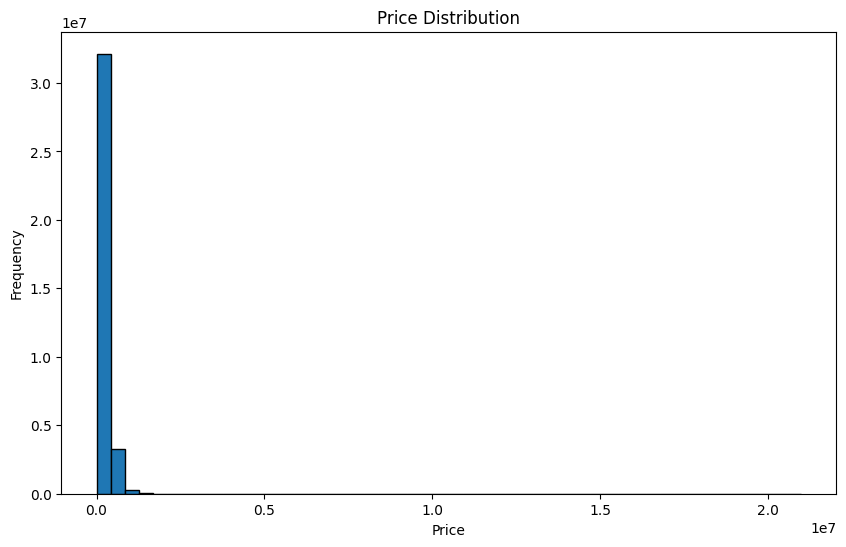

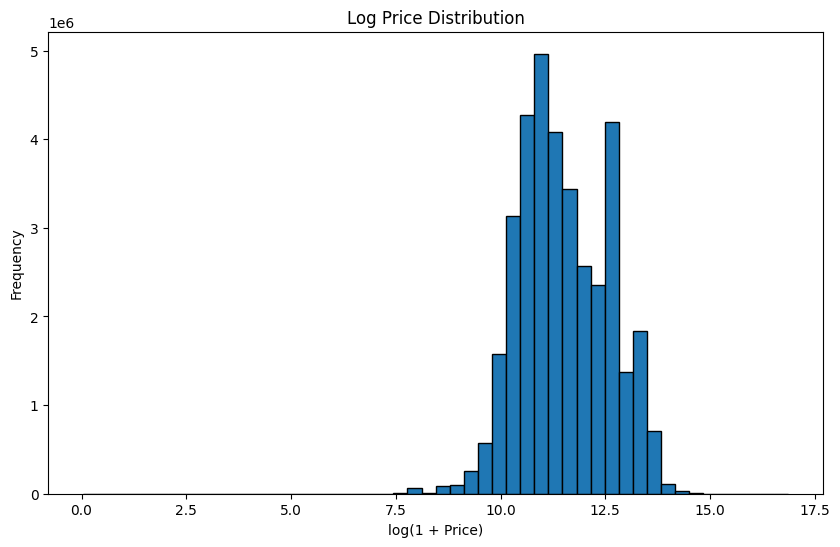


✅ Top sản phẩm có giá cao hơn 99% giá trị cột price (kèm category):
shape: (347_380, 3)
┌───────────────┬───────────────┬───────────────────────┐
│ item_id       ┆ price         ┆ category              │
│ ---           ┆ ---           ┆ ---                   │
│ str           ┆ decimal[38,4] ┆ str                   │
╞═══════════════╪═══════════════╪═══════════════════════╡
│ 5956000000001 ┆ 20990000.0000 ┆ Xe đẩy Combi          │
│ 5956000000001 ┆ 20990000.0000 ┆ Xe đẩy Combi          │
│ 5956000000001 ┆ 20990000.0000 ┆ Xe đẩy Combi          │
│ 5956000000001 ┆ 20805715.5399 ┆ Xe đẩy Combi          │
│ 5956000000001 ┆ 20793939.5604 ┆ Xe đẩy Combi          │
│ …             ┆ …             ┆ …                     │
│ 6699000000001 ┆ 805100.9608   ┆ Aptamil Hà Lan Step 1 │
│ 6700000000001 ┆ 805054.7404   ┆ Aptamil Hà Lan Step 2 │
│ 6700000000001 ┆ 805032.6144   ┆ Aptamil Hà Lan Step 2 │
│ 7242000000002 ┆ 805016.2536   ┆ Enspire Thái Step 3   │
│ 6700000000001 ┆ 805008.1112   ┆ Aptamil

In [24]:
# 1️⃣ Trích xuất dữ liệu price
price_stats = (
    purchase_history_df
    .select(pl.col("price").cast(pl.Float64))
    .collect()
)

price = price_stats["price"]

# 2️⃣ Thống kê cơ bản
print("Mean:", price.mean())
print("Median:", price.median())
print("Std:", price.std())
print("Skewness:", price.skew())

# 3️⃣ Biểu đồ phân phối gốc
plt.figure(figsize=(10,6))
plt.hist(price.drop_nulls().to_numpy(), bins=50, edgecolor='black')
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# 4️⃣ Biểu đồ log-transform
plt.figure(figsize=(10,6))
plt.hist(np.log1p(price.drop_nulls().to_numpy()), bins=50, edgecolor='black')
plt.title("Log Price Distribution")
plt.xlabel("log(1 + Price)")
plt.ylabel("Frequency")
plt.show()

p99 = (
    purchase_history_df
    .select(pl.col("price").cast(pl.Float64).quantile(0.99))
    .collect()
    .item()
)

high_price_items = (
    purchase_history_df
    .filter(pl.col("price").cast(pl.Float64) > p99)
    .select(["item_id", "price"])
    .sort("price", descending=True)
    .collect()
)

# 7️⃣ Join với bảng item_chunk_df để lấy category
high_price_with_category = (
    high_price_items.join(
        item_chunk_df.select(["item_id", "category"]),
        on="item_id",
        how="left"
    )
)

print("\n✅ Top sản phẩm có giá cao hơn 99% giá trị cột price (kèm category):")
print(high_price_with_category)


Mean: 1.5080983464094773
Median: 1.0
Std: 2.2649763532106966
Skewness: 10.642803747641423


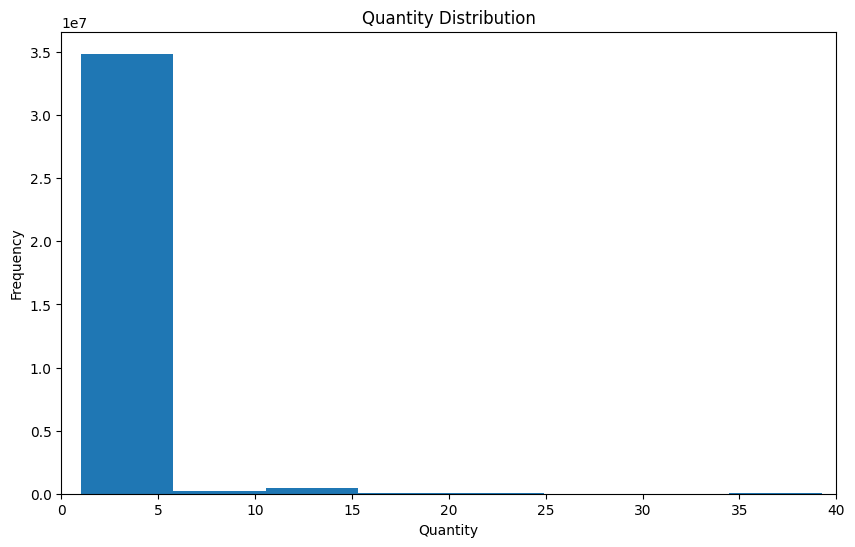

In [ ]:
quantity_stats = (
    purchase_history_df
    .select(pl.col("quantity").cast(pl.Float64))
    .collect()
)

quantity = quantity_stats["quantity"]

print("Mean:", quantity.mean())
print("Median:", quantity.median())
print("Std:", quantity.std())
print("Skewness:", quantity.skew())

plt.figure(figsize=(10,6))
plt.hist(quantity.drop_nulls().to_numpy(),bins=50)
plt.title("Quantity Distribution")
plt.xlabel("Quantity")
plt.xlim(0,40)
plt.ylabel("Frequency")
plt.show()


Mean: 1.5080983464094773
Median: 1.0
Std: 2.2649763532106966
Skewness: 10.642803747641423


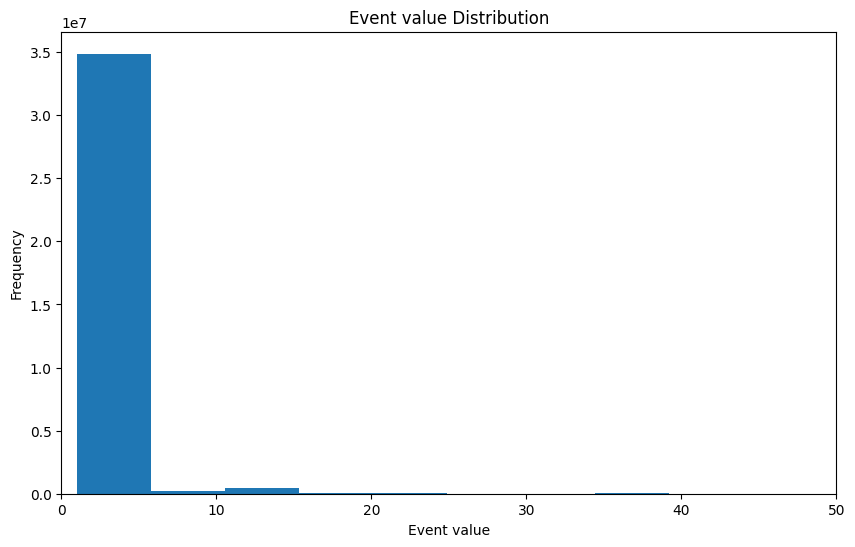

In [ ]:
event_value_stats = (
    purchase_history_df
    .select(pl.col("event_value").cast(pl.Float64))
    .collect()
)

event_value = event_value_stats["event_value"]

print("Mean:", event_value.mean())
print("Median:", event_value.median())
print("Std:", event_value.std())
print("Skewness:", event_value.skew())

plt.figure(figsize=(10,6))
plt.hist(event_value.drop_nulls().to_numpy(),bins=50)
plt.title("Event value Distribution")
plt.xlabel("Event value")
plt.xlim(0,50)
plt.ylabel("Frequency")
plt.show()

Mean: 17235.651914027356
Median: 0.0
Std: 46673.70849884546
Skewness: 9.69873858473305


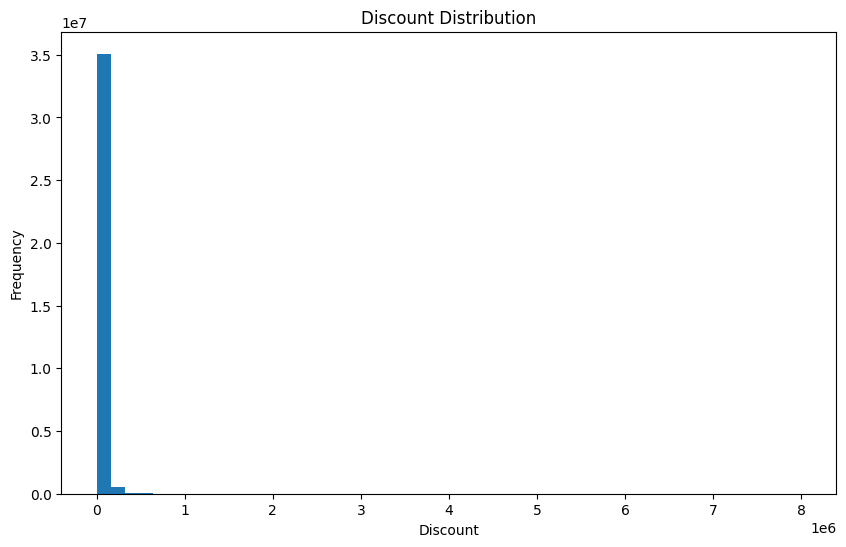

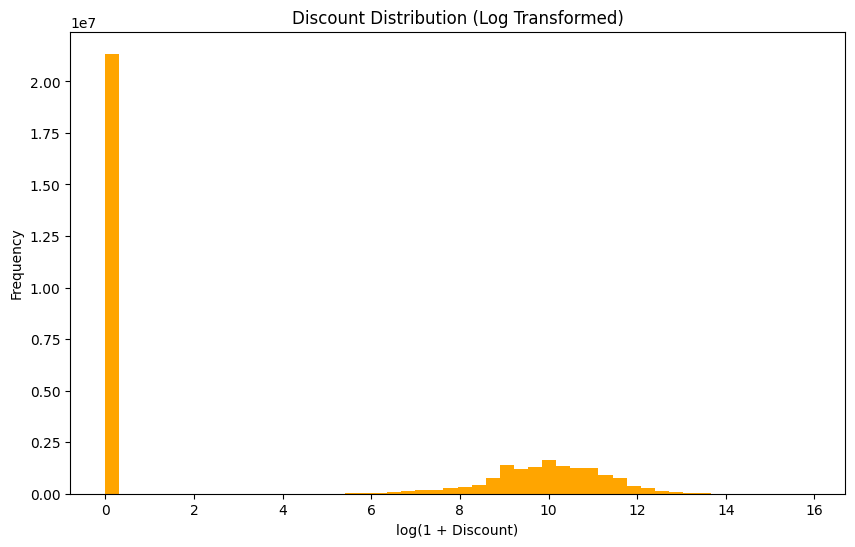

In [11]:
discount_stats = (
    purchase_history_df
    .select(pl.col("discount").cast(pl.Float64))
    .collect()
)

discount = discount_stats["discount"]

print("Mean:", discount.mean())
print("Median:", discount.median())
print("Std:", discount.std())
print("Skewness:", discount.skew())

plt.figure(figsize=(10,6))
plt.hist(discount.drop_nulls().to_numpy(),bins=50)
plt.title("Discount Distribution")
plt.xlabel("Discount")
plt.ylabel("Frequency")
plt.show()

discount_log = np.log1p(discount.drop_nulls().to_numpy())  # log(1 + x)

plt.figure(figsize=(10,6))
plt.hist(discount_log, bins=50, color='orange')
plt.title("Discount Distribution (Log Transformed)")
plt.xlabel("log(1 + Discount)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
corr_values = (
    purchase_history_df
    .select([
        pl.corr("event_value", "price").alias("event_value-price"),
        pl.corr("event_value", "quantity").alias("event_value-quantity"),
        pl.corr("event_value", "discount").alias("event_value-discount"),
        pl.corr("price", "quantity").alias("price-quantity"),
        pl.corr("price", "discount").alias("price-discount"),
        pl.corr("quantity", "discount").alias("quantity-discount"),
    ])
    .collect()
)

print(corr_values)

shape: (1, 6)
┌────────────────┬────────────────┬────────────────┬───────────────┬───────────────┬───────────────┐
│ event_value-pr ┆ event_value-qu ┆ event_value-di ┆ price-quantit ┆ price-discoun ┆ quantity-disc │
│ ice            ┆ antity         ┆ scount         ┆ y             ┆ t             ┆ ount          │
│ ---            ┆ ---            ┆ ---            ┆ ---           ┆ ---           ┆ ---           │
│ f64            ┆ f64            ┆ f64            ┆ f64           ┆ f64           ┆ f64           │
╞════════════════╪════════════════╪════════════════╪═══════════════╪═══════════════╪═══════════════╡
│ -0.074046      ┆ 1.0            ┆ 0.16637        ┆ -0.074046     ┆ 0.134046      ┆ 0.16637       │
└────────────────┴────────────────┴────────────────┴───────────────┴───────────────┴───────────────┘


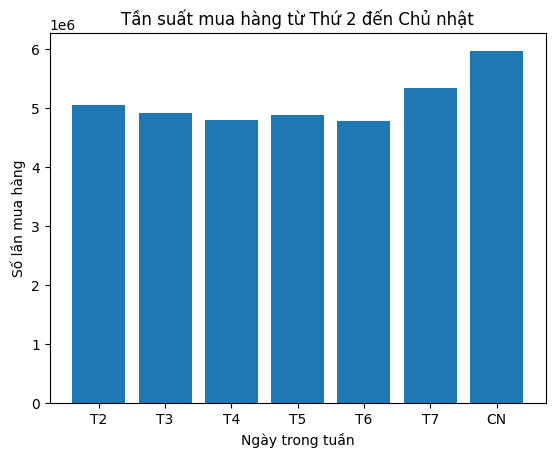

In [ ]:

df = purchase_history_df.with_columns(
    pl.col("created_date").dt.weekday().alias("day_of_week")
)

day_counts = (df
    .group_by("day_of_week")
    .agg(pl.len().alias("purchase_count"))
    .sort("day_of_week")
    .collect()
)
day_labels = ["T2", "T3", "T4", "T5", "T6", "T7", "CN"]

plt.bar(day_labels, day_counts["purchase_count"].to_list())
plt.xlabel("Ngày trong tuần")
plt.ylabel("Số lần mua hàng")
plt.title("Tần suất mua hàng từ Thứ 2 đến Chủ nhật")
plt.show()

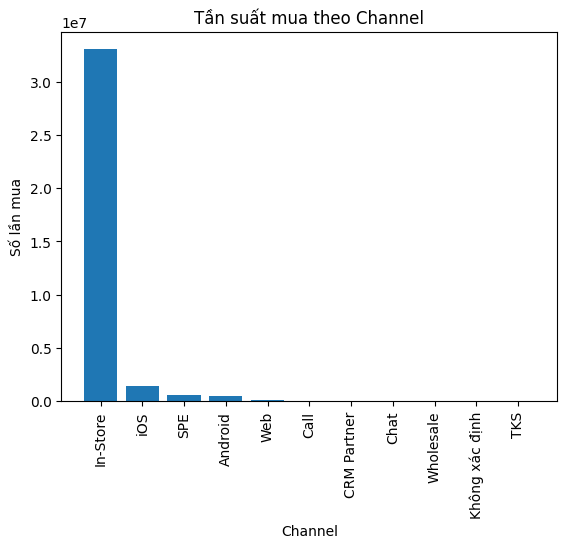

In [ ]:
counts = (
    purchase_history_df.group_by("channel")
      .agg(pl.len().alias("tổng"))
      .sort("tổng", descending=True)
      .collect()
)
plt.bar(counts["channel"].to_list(), counts["tổng"].to_list())
plt.xlabel("Channel")
plt.ylabel("Số lần mua")
plt.title("Tần suất mua theo Channel")
plt.xticks(rotation=90)
plt.show()

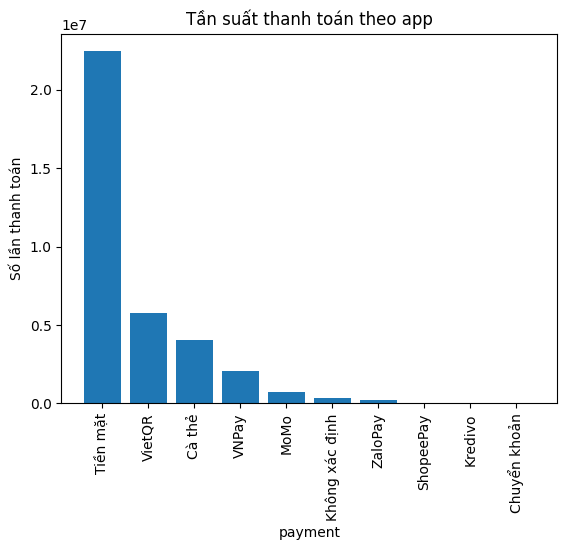

In [ ]:
counts = (purchase_history_df
      .group_by("payment")
      .agg(pl.len().alias("tổng"))
      .sort("tổng", descending=True)
      .collect()
)
plt.bar(counts["payment"].to_list(), counts["tổng"].to_list())
plt.xlabel("payment")
plt.ylabel("Số lần thanh toán")
plt.title("Tần suất thanh toán theo app")
plt.xticks(rotation=90)
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9236\2537639403.py:4: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("frequency"))


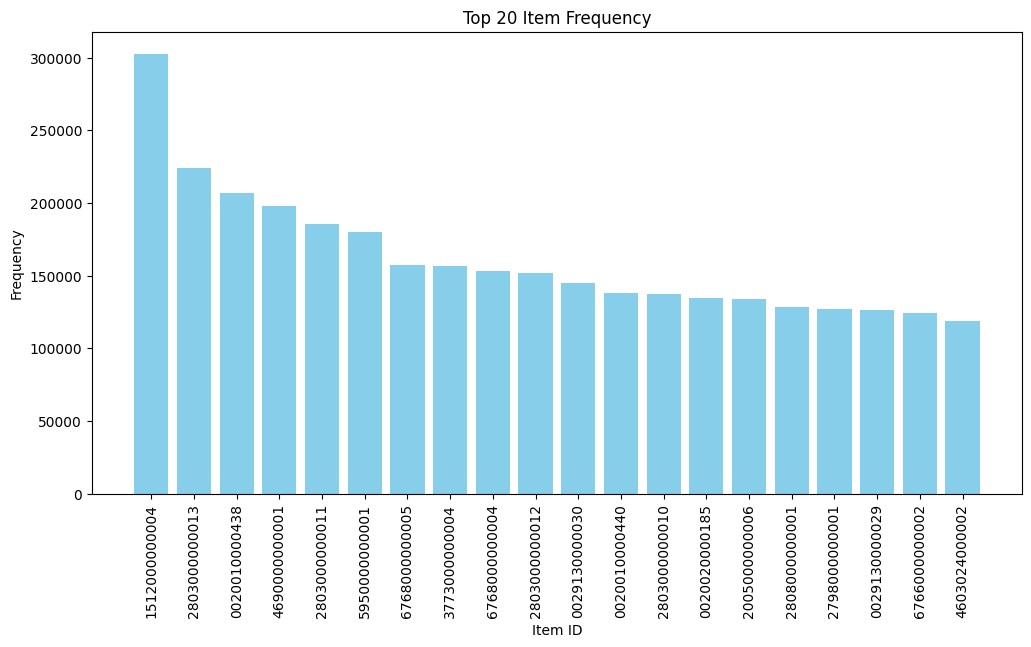

In [ ]:
item_freq = (
    purchase_history_df
    .group_by("item_id")
    .agg(pl.count().alias("frequency"))
    .sort("frequency", descending=True)
    .collect()
)

# 2. Chọn top 20 item_id để vẽ (không bị quá tải)
top_items = item_freq.head(20)

# 3. Vẽ bar plot
plt.figure(figsize=(12,6))
plt.bar(top_items["item_id"], top_items["frequency"], color="skyblue")
plt.xticks(rotation=90)
plt.xlabel("Item ID")
plt.ylabel("Frequency")
plt.title("Top 20 Item Frequency")
plt.show()

## **User Dataset**

In [8]:
files = glob.glob("data_full/sales_user/*.parquet")
user_df = pl.concat([pl.scan_parquet(f) for f in files])

In [9]:
user_df.head().collect()

customer_id,gender,location,province,membership,timestamp,created_date,updated_date,sync_status_id,last_sync_date,sync_error_message,region,location_name,install_app,install_date,district,user_id,is_deleted
i32,str,i32,str,str,i64,datetime[μs],datetime[μs],i32,datetime[μs],str,str,str,str,i64,str,str,bool
14732,"""Nam""",155,"""Hồ Chí Minh""","""Standard""",1306357911,2011-05-25 21:11:51.677,2025-07-07 15:33:10.201316,2,2025-07-16 11:54:29.816986,null,"""Đông Nam Bộ""","""HCM - Grand View Phú Mỹ Hưng""","""In-Store""",1306281600,"""7""","""e1e48206652bf8c279ff0206c69a80…",false
15126,"""Nữ""",300,"""Hồ Chí Minh""","""Standard""",1306357911,2011-05-25 21:11:51.677,2025-07-07 15:33:10.201316,2,2025-07-16 11:54:29.816986,null,"""Đông Nam Bộ""","""HCM - 121A Nguyễn Duy Trinh""","""In-Store""",1306281600,"""Thủ Đức""","""77891759204bd27e69fb11a7b92889…",false
29718,"""Nữ""",157,"""Bến Tre""","""Standard""",1312126692,2011-07-31 15:38:12.750,2025-07-07 15:33:10.201316,2,2025-07-16 11:54:29.816986,null,"""Đồng bằng sông Cửu Long""","""BTR - 179 Nguyễn Đình Chiểu""","""In-Store""",1582070400,"""Bến Tre""","""b8041b584a0bb6655361727a0a6108…",false
30077,"""Nữ""",53,"""Hồ Chí Minh""","""Standard""",1314302782,2011-08-25 20:06:22.797,2025-07-07 15:33:10.201316,2,2025-07-16 11:54:29.816986,null,"""Đông Nam Bộ""","""HCM - 101 Trần Quang Khải""","""In-Store""",1314230400,"""1""","""c52ceaca44a83ec41a219cfaff0e05…",false
30085,"""Nữ""",660,"""Hồ Chí Minh""","""Standard""",1314310024,2011-08-25 22:07:04.267,2025-07-07 15:33:10.201316,2,2025-07-16 11:54:29.816986,null,"""Đông Nam Bộ""","""HCM - 85-87 Tây Thạnh""","""In-Store""",1314230400,"""Tân Phú""","""74ac5764f5d67d341aacf238d7762f…",false


In [13]:
row_count = user_df.select(pl.len()).collect().item()
col_count = len(user_df.collect_schema().names())
print(f"Kích thước: {row_count:,} dòng × {col_count} cột")

print("Schema:")
for name, dtype in user_df.schema.items():
    print(f"{name}: {dtype}")

print(user_df.describe())

lazy_null_summary(user_df)

Kích thước: 4,573,964 dòng × 18 cột
Schema:
customer_id: Int32
gender: String
location: Int32
province: String
membership: String
timestamp: Int64
created_date: Datetime(time_unit='us', time_zone=None)
updated_date: Datetime(time_unit='us', time_zone=None)
sync_status_id: Int32
last_sync_date: Datetime(time_unit='us', time_zone=None)
sync_error_message: String
region: String
location_name: String
install_app: String
install_date: Int64
district: String
user_id: String
is_deleted: Boolean


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_27144\4104837440.py:6: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  for name, dtype in user_df.schema.items():


shape: (9, 19)
┌────────────┬─────────────┬─────────┬────────────┬───┬──────────────┬────────────┬───────────────────────┬────────────┐
│ statistic  ┆ customer_id ┆ gender  ┆ location   ┆ … ┆ install_date ┆ district   ┆ user_id               ┆ is_deleted │
│ ---        ┆ ---         ┆ ---     ┆ ---        ┆   ┆ ---          ┆ ---        ┆ ---                   ┆ ---        │
│ str        ┆ f64         ┆ str     ┆ f64        ┆   ┆ f64          ┆ str        ┆ str                   ┆ f64        │
╞════════════╪═════════════╪═════════╪════════════╪═══╪══════════════╪════════════╪═══════════════════════╪════════════╡
│ count      ┆ 4.573964e6  ┆ 4573964 ┆ 4.573964e6 ┆ … ┆ 4.573964e6   ┆ 4573964    ┆ 4573964               ┆ 4.573964e6 │
│ null_count ┆ 0.0         ┆ 0       ┆ 0.0        ┆ … ┆ 0.0          ┆ 0          ┆ 0                     ┆ 0.0        │
│ mean       ┆ 6.1266e6    ┆ null    ┆ 554.053518 ┆ … ┆ 1.6841e9     ┆ null       ┆ null                  ┆ 0.0        │
│ std        ┆ 2.

column,null_count,null_percent
str,u32,f64
"""sync_error_message""",4573964,100.0
"""sync_status_id""",338285,7.395882
"""last_sync_date""",338285,7.395882
"""customer_id""",0,0.0
"""gender""",0,0.0
…,…,…
"""install_app""",0,0.0
"""install_date""",0,0.0
"""district""",0,0.0


In [ ]:
cols = user_df.collect_schema().names()
unique_counts = (
    user_df.select([pl.col(c).n_unique().alias(c) for c in cols])
    .collect()
    .transpose(include_header=True, header_name="column", column_names=["n_unique"])
)
unique_counts = unique_counts.sort("n_unique", descending=True)
print(unique_counts)
low_info_cols = unique_counts.filter(pl.col("n_unique") <= 5)
print(low_info_cols)

shape: (18, 2)
┌────────────────────┬──────────┐
│ column             ┆ n_unique │
│ ---                ┆ ---      │
│ str                ┆ u32      │
╞════════════════════╪══════════╡
│ customer_id        ┆ 4573964  │
│ user_id            ┆ 4573964  │
│ created_date       ┆ 4570591  │
│ timestamp          ┆ 4457031  │
│ updated_date       ┆ 1686792  │
│ …                  ┆ …        │
│ gender             ┆ 3        │
│ membership         ┆ 3        │
│ sync_status_id     ┆ 2        │
│ sync_error_message ┆ 1        │
│ is_deleted         ┆ 1        │
└────────────────────┴──────────┘
shape: (5, 2)
┌────────────────────┬──────────┐
│ column             ┆ n_unique │
│ ---                ┆ ---      │
│ str                ┆ u32      │
╞════════════════════╪══════════╡
│ gender             ┆ 3        │
│ membership         ┆ 3        │
│ sync_status_id     ┆ 2        │
│ sync_error_message ┆ 1        │
│ is_deleted         ┆ 1        │
└────────────────────┴──────────┘


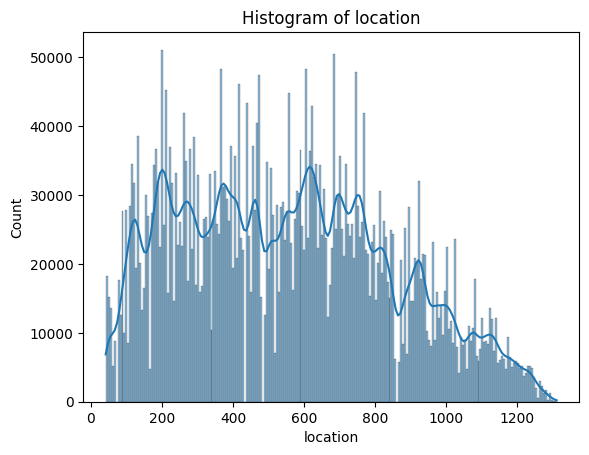

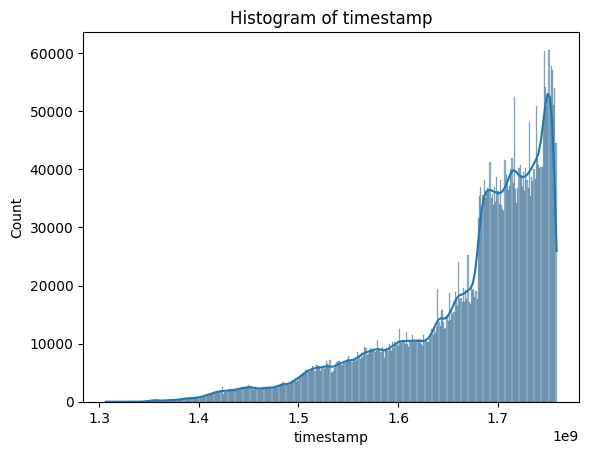

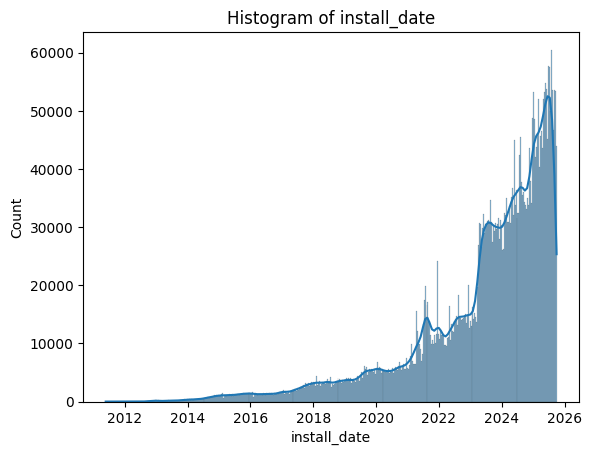

In [ ]:
num_df = user_df.select(['location', 'timestamp', 'install_date']).collect().to_pandas()
num_df['install_date'] = pd.to_datetime(num_df['install_date'], unit='s', errors='coerce')
for col in num_df.columns:
     sns.histplot(num_df[col], kde=True)
     plt.title(f'Histogram of {col}')
     plt.show()

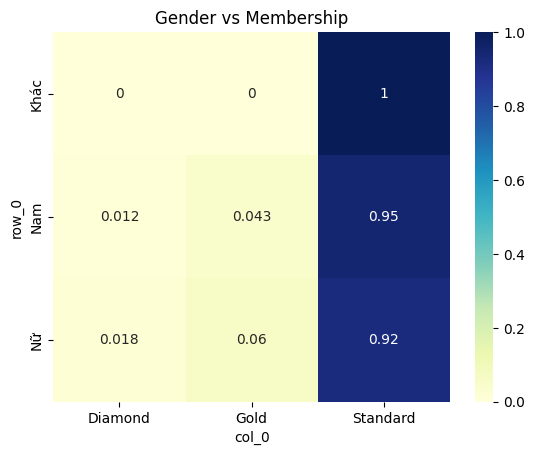

In [ ]:
df = user_df.select(['gender', 'membership']).collect()
cross_tab = pd.crosstab(df['gender'], df['membership'], normalize='index')
sns.heatmap(cross_tab, annot=True, cmap='YlGnBu')
plt.title("Gender vs Membership")
plt.show()


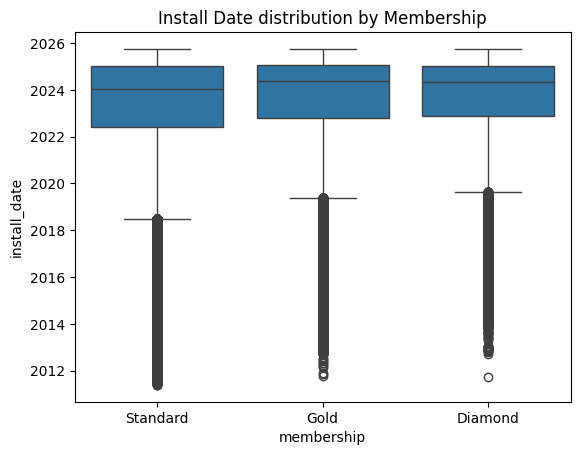

In [ ]:
df_pd = user_df.select(['install_date', 'membership']).collect().to_pandas()

df_pd['install_date'] = pd.to_datetime(df_pd['install_date'], unit='s', errors='coerce')

sns.boxplot(x='membership', y='install_date', data=df_pd)
plt.title("Install Date distribution by Membership")
plt.show()

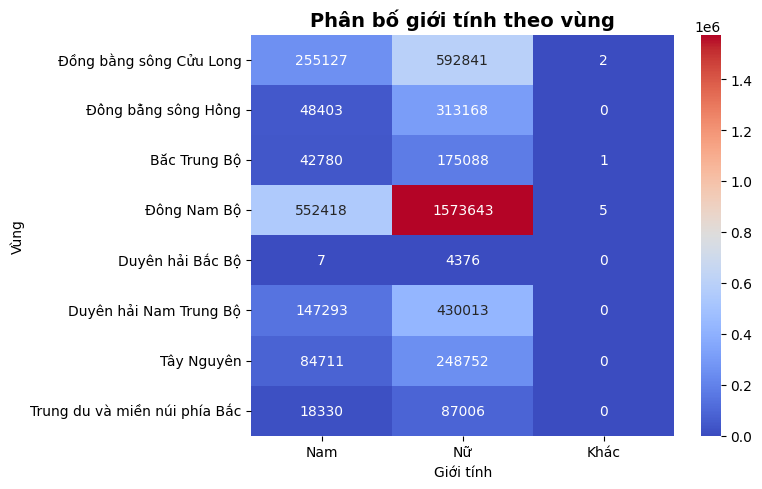

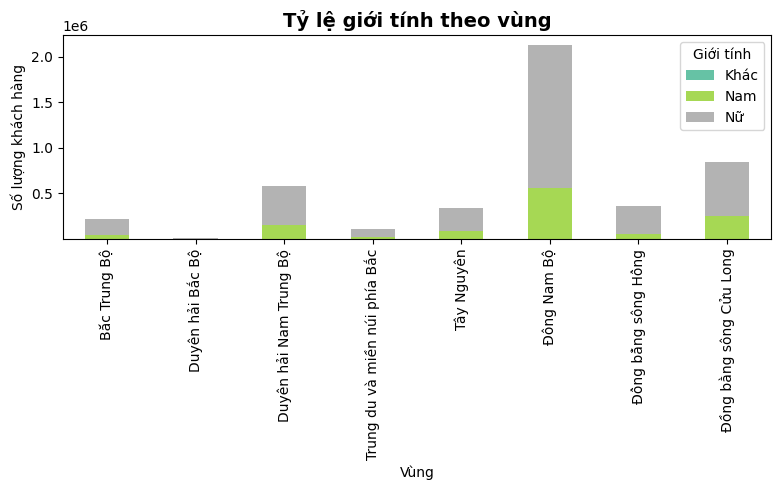

In [28]:
# 2️⃣ Gom nhóm theo giới tính và vùng
gender_region = (
    user_df
    .group_by(["region", "gender"])
    .agg(pl.count("customer_id").alias("count"))
    .collect()
)

# 3️⃣ Pivot đúng cú pháp mới của Polars
pivot_df = gender_region.pivot(
    values="count",
    index="region",
    on="gender"   # ✅ thay vì columns=
).fill_null(0)

# Chuyển sang pandas
pd_pivot = pivot_df.to_pandas().set_index("region")

# 4️⃣ Vẽ heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(pd_pivot, annot=True, fmt=".0f", cmap="coolwarm")
plt.title("Phân bố giới tính theo vùng", fontsize=14, weight="bold")
plt.xlabel("Giới tính")
plt.ylabel("Vùng")
plt.tight_layout()
plt.show()

# 5️⃣ Vẽ stacked bar chart
pd_df = gender_region.to_pandas()
pivot_bar = pd_df.pivot(index="region", columns="gender", values="count").fillna(0)

pivot_bar.plot(kind="bar", stacked=True, colormap="Set2", figsize=(8, 5))
plt.title("Tỷ lệ giới tính theo vùng", fontsize=14, weight="bold")
plt.ylabel("Số lượng khách hàng")
plt.xlabel("Vùng")
plt.legend(title="Giới tính")
plt.tight_layout()
plt.show()


# Tiền xử lý dữ liệu


## Item Chunk

In [10]:
df_corr= (
    item_chunk_df
    .select(["p_id", "item_id"])
    .filter(pl.col("p_id").is_not_null() & pl.col("item_id").is_not_null())
)

# 3️⃣ Kiểm tra cơ bản
print("🔹 Số lượng dòng:", df_corr.height)
print("🔹 Số p_id duy nhất:", df_corr['p_id'].n_unique())
print("🔹 Số item_id duy nhất:", df_corr['item_id'].n_unique())

# 4️⃣ Tính hệ số tương quan
corr_value = df_corr["p_id"].to_pandas().corr(df_corr["item_id"].to_pandas())
print(f"📈 Hệ số tương quan (Pearson): {corr_value:.4f}")

🔹 Số lượng dòng: 27332
🔹 Số p_id duy nhất: 27332
🔹 Số item_id duy nhất: 27332
📈 Hệ số tương quan (Pearson): 0.7399


In [11]:
item_chunk_df=item_chunk_df.drop(['is_deleted','sync_status_id','last_sync_date','sync_error_message','weight','image_url','color','size','volume','description_new','p_id','manufacturer','origin'])


In [12]:
item_chunk_df.head()

item_id,price,category_l1_id,category_l1,category_l2_id,category_l2,category_l3_id,category_l3,category_id,category,description,brand,creation_timestamp,created_date,updated_date,gender_target,age_group,item_type,gp,material,sale_status
str,"decimal[38,4]",i32,str,i32,str,i32,str,i32,str,str,str,i64,datetime[μs],datetime[μs],str,str,str,"decimal[38,4]",str,i32
"""0502020000004""",99000.0000,1,"""Babycare""",35,"""Bình sữa, phụ kiện""",7050,"""Núm ty""",7058,"""Núm ty Dr Brown""","""Không xác định""","""Dr.Brown's""",1333531544,2012-04-04 09:25:44.240,2025-08-18 09:59:19.847,"""Không xác định""","""Không xác định""","""Không xác định""",36828.0000,"""Không xác định""",0
"""0010290040150""",69000.0000,3292,"""Thời trang""",3958,"""Cơ cấu hàng cũ""",7007,"""Thời trang bé trai, bé gái cũ""",6987,"""Bộ quần áo bé gái""","""Không xác định""","""Con Cưng""",1503046250,2017-08-18 08:50:50.713,2025-09-18 16:05:42.360,"""Bé Gái""","""Từ 3Y""","""Bộ quần áo""",0.0000,"""Không xác định""",0
"""0008010000015""",45000.0000,351,"""Đồ chơi & Sách""",2033,"""0-1Y""",2118,"""Gặm nướu""",2121,"""Gặm nướu khác""","""- Chất liệu: Sản phẩm được làm…","""Thương hiệu khác""",1358501584,2013-01-18 09:33:04.260,2025-09-27 00:05:36.233,"""Không xác định""","""Không xác định""","""Không xác định""",14490.0000,"""Không xác định""",0
"""0020010000094""",401000.0000,2222,"""Tã""",2272,"""Merries""",2275,"""Merries""",2276,"""Merries_Sơ Sinh""","""﻿﻿Tã dán Merries size S 82 miế…","""Merries Nhật""",1400062039,2014-05-14 10:07:19.603,2025-09-27 00:05:36.233,"""Không xác định""","""Không xác định""","""Không xác định""",59749.0000,"""Giấy, bột giấy, vải không dệt,…",0
"""0020010000098""",401000.0000,2222,"""Tã""",2272,"""Merries""",2275,"""Merries""",2278,"""Merries_Tã Quần""","""﻿﻿﻿Bỉm tã quần Merries size M …","""Merries Nhật""",1400062040,2014-05-14 10:07:20.370,2025-09-27 00:05:36.233,"""Không xác định""","""Không xác định""","""Không xác định""",65764.0000,"""Giấy, bột giấy, vải không dệt,…",0


In [13]:
# label encoding cột gender_target
item_chunk_df_lazy = item_chunk_df.lazy()

expr = (
    pl.when(pl.col("gender_target") == "Bé Gái").then(0)
    .when(pl.col("gender_target") == "Bé Trai").then(1)
    .when(pl.col("gender_target") == "Không xác định").then(2)
    .when(pl.col("gender_target") == "Sơ sinh").then(3)
    .when(pl.col("gender_target") == "Unisex").then(4)
    .otherwise(-1)
)

item_chunk_df_lazy = item_chunk_df_lazy.with_columns([
    expr.alias("gender_target_encode")
])
item_chunk_df = item_chunk_df_lazy.collect()
print(item_chunk_df.select(["gender_target", "gender_target_encode"]).head(10))
item_chunk_df = item_chunk_df.drop("gender_target")
item_chunk_df = item_chunk_df.rename({"gender_target_encode": "gender_target"})

shape: (10, 2)
┌────────────────┬──────────────────────┐
│ gender_target  ┆ gender_target_encode │
│ ---            ┆ ---                  │
│ str            ┆ i32                  │
╞════════════════╪══════════════════════╡
│ Không xác định ┆ 2                    │
│ Bé Gái         ┆ 0                    │
│ Không xác định ┆ 2                    │
│ Không xác định ┆ 2                    │
│ Không xác định ┆ 2                    │
│ Bé Trai        ┆ 1                    │
│ Không xác định ┆ 2                    │
│ Không xác định ┆ 2                    │
│ Không xác định ┆ 2                    │
│ Không xác định ┆ 2                    │
└────────────────┴──────────────────────┘


In [14]:
#label enccoding top 10 thương hiệu được mua nhiều còn các thương hiện khác đưa về cùng 1 label 
top_brands = (
    item_chunk_df
    .group_by("brand")
    .agg(pl.len().alias("brand_count"))
    .sort("brand_count", descending=True)
    .head(10)
)

top_brand_list = top_brands["brand"].to_list()
item_chunk_df = item_chunk_df.with_columns([
    pl.when(pl.col("brand").is_in(top_brand_list))
    .then(pl.col("brand"))
    .otherwise(pl.lit("Other"))
    .alias("brand")
])

unique_brands = item_chunk_df["brand"].unique().to_list()
brand_mapping = {b: i for i, b in enumerate(unique_brands)}

item_chunk_df = item_chunk_df.with_columns([
    pl.col("brand").map_elements(lambda x: brand_mapping.get(x, -1)).alias("brand")
])

print(item_chunk_df.select(["brand"]).head(15))
print(f"Tổng số brand sau khi mã hóa: {len(unique_brands)}")
print("Mapping:", brand_mapping)

shape: (15, 1)
┌───────┐
│ brand │
│ ---   │
│ i64   │
╞═══════╡
│ 9     │
│ 8     │
│ 10    │
│ 9     │
│ 9     │
│ …     │
│ 0     │
│ 9     │
│ 9     │
│ 9     │
│ 9     │
└───────┘
Tổng số brand sau khi mã hóa: 11
Mapping: {'CF (ConCung Fashion)': 0, 'Animo': 1, 'Mesuca': 2, 'Pigeon': 3, 'ConCung Good': 4, 'Không xác định': 5, 'Nous': 6, 'TOYCITY': 7, 'Con Cưng': 8, 'Other': 9, 'Thương hiệu khác': 10}


In [15]:
# item_chunk_df sau khi label encoding 1 số cột 
item_chunk_df.head()

item_id,price,category_l1_id,category_l1,category_l2_id,category_l2,category_l3_id,category_l3,category_id,category,description,brand,creation_timestamp,created_date,updated_date,age_group,item_type,gp,material,sale_status,gender_target
str,"decimal[38,4]",i32,str,i32,str,i32,str,i32,str,str,i64,i64,datetime[μs],datetime[μs],str,str,"decimal[38,4]",str,i32,i32
"""0502020000004""",99000.0000,1,"""Babycare""",35,"""Bình sữa, phụ kiện""",7050,"""Núm ty""",7058,"""Núm ty Dr Brown""","""Không xác định""",9,1333531544,2012-04-04 09:25:44.240,2025-08-18 09:59:19.847,"""Không xác định""","""Không xác định""",36828.0000,"""Không xác định""",0,2
"""0010290040150""",69000.0000,3292,"""Thời trang""",3958,"""Cơ cấu hàng cũ""",7007,"""Thời trang bé trai, bé gái cũ""",6987,"""Bộ quần áo bé gái""","""Không xác định""",8,1503046250,2017-08-18 08:50:50.713,2025-09-18 16:05:42.360,"""Từ 3Y""","""Bộ quần áo""",0.0000,"""Không xác định""",0,0
"""0008010000015""",45000.0000,351,"""Đồ chơi & Sách""",2033,"""0-1Y""",2118,"""Gặm nướu""",2121,"""Gặm nướu khác""","""- Chất liệu: Sản phẩm được làm…",10,1358501584,2013-01-18 09:33:04.260,2025-09-27 00:05:36.233,"""Không xác định""","""Không xác định""",14490.0000,"""Không xác định""",0,2
"""0020010000094""",401000.0000,2222,"""Tã""",2272,"""Merries""",2275,"""Merries""",2276,"""Merries_Sơ Sinh""","""﻿﻿Tã dán Merries size S 82 miế…",9,1400062039,2014-05-14 10:07:19.603,2025-09-27 00:05:36.233,"""Không xác định""","""Không xác định""",59749.0000,"""Giấy, bột giấy, vải không dệt,…",0,2
"""0020010000098""",401000.0000,2222,"""Tã""",2272,"""Merries""",2275,"""Merries""",2278,"""Merries_Tã Quần""","""﻿﻿﻿Bỉm tã quần Merries size M …",9,1400062040,2014-05-14 10:07:20.370,2025-09-27 00:05:36.233,"""Không xác định""","""Không xác định""",65764.0000,"""Giấy, bột giấy, vải không dệt,…",0,2


In [16]:
today = datetime.now()
item__chunk_features_df = item_chunk_df.select([
    "item_id",  # Mã sản phẩm
    (pl.col("gp") / (pl.col("price") + 1)).alias("margin_ratio"),  # Tỷ lệ lợi nhuận trên giá bán
    (pl.lit(today) - pl.col("created_date")).dt.total_days().alias("product_age_days")  # Số ngày từ lần cập nhật cuối
])

item_chunk_df = item_chunk_df.join(
    item__chunk_features_df,
    on="item_id",
    how="left"
)
item__chunk_features_df

item_id,margin_ratio,product_age_days
str,"decimal[38,4]",i64
"""0502020000004""",0.3720,4956
"""0010290040150""",0.0000,2994
"""0008010000015""",0.3220,4667
"""0020010000094""",0.1490,4186
"""0020010000098""",0.1640,4186
…,…,…
"""3389000000238""",0.4216,251
"""3389000000212""",0.4216,251
"""3389000000213""",0.4216,251


In [17]:
item_chunk_df.head()

item_id,price,category_l1_id,category_l1,category_l2_id,category_l2,category_l3_id,category_l3,category_id,category,description,brand,creation_timestamp,created_date,updated_date,age_group,item_type,gp,material,sale_status,gender_target,margin_ratio,product_age_days
str,"decimal[38,4]",i32,str,i32,str,i32,str,i32,str,str,i64,i64,datetime[μs],datetime[μs],str,str,"decimal[38,4]",str,i32,i32,"decimal[38,4]",i64
"""0502020000004""",99000.0000,1,"""Babycare""",35,"""Bình sữa, phụ kiện""",7050,"""Núm ty""",7058,"""Núm ty Dr Brown""","""Không xác định""",9,1333531544,2012-04-04 09:25:44.240,2025-08-18 09:59:19.847,"""Không xác định""","""Không xác định""",36828.0000,"""Không xác định""",0,2,0.3720,4956
"""0010290040150""",69000.0000,3292,"""Thời trang""",3958,"""Cơ cấu hàng cũ""",7007,"""Thời trang bé trai, bé gái cũ""",6987,"""Bộ quần áo bé gái""","""Không xác định""",8,1503046250,2017-08-18 08:50:50.713,2025-09-18 16:05:42.360,"""Từ 3Y""","""Bộ quần áo""",0.0000,"""Không xác định""",0,0,0.0000,2994
"""0008010000015""",45000.0000,351,"""Đồ chơi & Sách""",2033,"""0-1Y""",2118,"""Gặm nướu""",2121,"""Gặm nướu khác""","""- Chất liệu: Sản phẩm được làm…",10,1358501584,2013-01-18 09:33:04.260,2025-09-27 00:05:36.233,"""Không xác định""","""Không xác định""",14490.0000,"""Không xác định""",0,2,0.3220,4667
"""0020010000094""",401000.0000,2222,"""Tã""",2272,"""Merries""",2275,"""Merries""",2276,"""Merries_Sơ Sinh""","""﻿﻿Tã dán Merries size S 82 miế…",9,1400062039,2014-05-14 10:07:19.603,2025-09-27 00:05:36.233,"""Không xác định""","""Không xác định""",59749.0000,"""Giấy, bột giấy, vải không dệt,…",0,2,0.1490,4186
"""0020010000098""",401000.0000,2222,"""Tã""",2272,"""Merries""",2275,"""Merries""",2278,"""Merries_Tã Quần""","""﻿﻿﻿Bỉm tã quần Merries size M …",9,1400062040,2014-05-14 10:07:20.370,2025-09-27 00:05:36.233,"""Không xác định""","""Không xác định""",65764.0000,"""Giấy, bột giấy, vải không dệt,…",0,2,0.1640,4186


In [18]:
# xác định sản phẩm theo nhóm tuổi 

# Hàm chuẩn hóa và chia nhỏ nhóm tuổi thành các mốc 6 tháng
def normalize_and_split_age_group(age_str: str):
    # Trả về rỗng nếu không có dữ liệu hoặc không xác định
    if not age_str or age_str.strip() == "" or age_str == "Không xác định":
        return []

    # Chuẩn hóa chuỗi: viết hoa, bỏ khoảng trắng
    s = age_str.upper().replace(" ", "")

    # Hàm phụ chuyển đổi chuỗi tuổi sang số tháng
    def to_months(value: str) -> int:
        years = months = 0
        y_match = re.search(r'(\d+)Y', value)  # tìm số năm
        m_match = re.search(r'(\d+)M', value)  # tìm số tháng
        if y_match:
            years = int(y_match.group(1))
        if m_match:
            months = int(m_match.group(1))
        if not y_match and not m_match and value.isdigit():
            months = int(value)
        return years * 12 + months  # quy đổi ra tháng

    # Xác định khoảng tuổi bắt đầu và kết thúc
    parts = re.split(r'[-–]', s)
    if len(parts) == 2:  # dạng 1Y-3Y
        start = to_months(parts[0])
        end = to_months(parts[1])
    elif "TỪ" in s:  # dạng TỪ 1Y
        start = to_months(re.search(r'(\d+[MY])', s).group(1))
        end = start + 60  # giả định thêm 5 năm
    elif "TRÊN" in s:  # dạng TRÊN 3Y
        start = to_months(re.search(r'(\d+[MY])', s).group(1))
        end = start + 60
    else:  # dạng 6M hoặc 1Y
        start = to_months(s)
        end = start

    # Trả về danh sách các mốc tuổi cách nhau 6 tháng
    return [f"{m}M" for m in range(start, end + 1, 6)]


# Tạo cột mới age_group_list chứa danh sách nhóm tuổi cho mỗi sản phẩm
item_chunk_df = item_chunk_df.with_columns([
    pl.col("age_group")
      .map_elements(normalize_and_split_age_group, return_dtype=pl.List(pl.Utf8))
      .alias("age_group_list")
])

item_chunk_df.head()

item_id,price,category_l1_id,category_l1,category_l2_id,category_l2,category_l3_id,category_l3,category_id,category,description,brand,creation_timestamp,created_date,updated_date,age_group,item_type,gp,material,sale_status,gender_target,margin_ratio,product_age_days,age_group_list
str,"decimal[38,4]",i32,str,i32,str,i32,str,i32,str,str,i64,i64,datetime[μs],datetime[μs],str,str,"decimal[38,4]",str,i32,i32,"decimal[38,4]",i64,list[str]
"""0502020000004""",99000.0000,1,"""Babycare""",35,"""Bình sữa, phụ kiện""",7050,"""Núm ty""",7058,"""Núm ty Dr Brown""","""Không xác định""",9,1333531544,2012-04-04 09:25:44.240,2025-08-18 09:59:19.847,"""Không xác định""","""Không xác định""",36828.0000,"""Không xác định""",0,2,0.3720,4956,[]
"""0010290040150""",69000.0000,3292,"""Thời trang""",3958,"""Cơ cấu hàng cũ""",7007,"""Thời trang bé trai, bé gái cũ""",6987,"""Bộ quần áo bé gái""","""Không xác định""",8,1503046250,2017-08-18 08:50:50.713,2025-09-18 16:05:42.360,"""Từ 3Y""","""Bộ quần áo""",0.0000,"""Không xác định""",0,0,0.0000,2994,"[""36M"", ""42M"", … ""96M""]"
"""0008010000015""",45000.0000,351,"""Đồ chơi & Sách""",2033,"""0-1Y""",2118,"""Gặm nướu""",2121,"""Gặm nướu khác""","""- Chất liệu: Sản phẩm được làm…",10,1358501584,2013-01-18 09:33:04.260,2025-09-27 00:05:36.233,"""Không xác định""","""Không xác định""",14490.0000,"""Không xác định""",0,2,0.3220,4667,[]
"""0020010000094""",401000.0000,2222,"""Tã""",2272,"""Merries""",2275,"""Merries""",2276,"""Merries_Sơ Sinh""","""﻿﻿Tã dán Merries size S 82 miế…",9,1400062039,2014-05-14 10:07:19.603,2025-09-27 00:05:36.233,"""Không xác định""","""Không xác định""",59749.0000,"""Giấy, bột giấy, vải không dệt,…",0,2,0.1490,4186,[]
"""0020010000098""",401000.0000,2222,"""Tã""",2272,"""Merries""",2275,"""Merries""",2278,"""Merries_Tã Quần""","""﻿﻿﻿Bỉm tã quần Merries size M …",9,1400062040,2014-05-14 10:07:20.370,2025-09-27 00:05:36.233,"""Không xác định""","""Không xác định""",65764.0000,"""Giấy, bột giấy, vải không dệt,…",0,2,0.1640,4186,[]


In [25]:
# chứng minh khi người dùng càng lớn nhu cầu mua sữa càng ít 
milk_df = (
    item_chunk_df.filter(
        (pl.col("category_l1") == "Sữa") &
        (~pl.col("age_group").str.contains("Không xác định"))
    )
)

milk_purchase_df = purchase_history_df.join(
    milk_df,
    on="item_id",
    how="inner"  # hoặc "left" nếu muốn giữ toàn bộ lịch sử mua hàng
)
print(milk_purchase_df.shape)
milk_purchase_small = milk_purchase_df.select([
    "user_id",
    "item_id",
    "quantity",
    "customer_id",
    "age_group_list",
    "category_l1",
    "age_group"
])

milk_purchase_small.head()


purchase_by_age_group_list = (
    milk_purchase_small
    .group_by("age_group_list")
    .agg(pl.count().alias("total_purchases"))
    .sort("total_purchases")  # sắp xếp từ nhiều -> ít
)

print(purchase_by_age_group_list)

(3788069, 38)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13248\2139082331.py:30: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("total_purchases"))


shape: (24, 2)
┌──────────────────────────┬─────────────────┐
│ age_group_list           ┆ total_purchases │
│ ---                      ┆ ---             │
│ list[str]                ┆ u32             │
╞══════════════════════════╪═════════════════╡
│ ["18M", "24M", … "78M"]  ┆ 71              │
│ ["12M", "18M"]           ┆ 76              │
│ ["12M", "18M", … "144M"] ┆ 288             │
│ ["9M", "15M", … "33M"]   ┆ 1773            │
│ ["36M", "42M", … "144M"] ┆ 5180            │
│ …                        ┆ …               │
│ ["12M", "18M", … "120M"] ┆ 211150          │
│ ["6M", "12M"]            ┆ 445291          │
│ ["0M", "6M"]             ┆ 512192          │
│ ["12M", "18M", "24M"]    ┆ 619901          │
│ ["0M", "6M", "12M"]      ┆ 981403          │
└──────────────────────────┴─────────────────┘


In [37]:
item_chunk_df = item_chunk_df.with_columns(
    pl.when(pl.col("price") > p99)
      .then(p99)
      .otherwise(pl.col("price"))
      .log1p()
      .alias("price_log")
)
print(item_chunk_df.select(["price", "price_log"]).head(10))
item_chunk_df = item_chunk_df.drop("price")
item_chunk_df = item_chunk_df.rename({"price_log": "price"})


shape: (10, 2)
┌───────────────┬───────────┐
│ price         ┆ price_log │
│ ---           ┆ ---       │
│ decimal[38,4] ┆ f64       │
╞═══════════════╪═══════════╡
│ 99000.0000    ┆ 11.502885 │
│ 69000.0000    ┆ 11.141876 │
│ 45000.0000    ┆ 10.71444  │
│ 401000.0000   ┆ 12.901719 │
│ 401000.0000   ┆ 12.901719 │
│ 49000.0000    ┆ 10.799596 │
│ 425000.0000   ┆ 12.959847 │
│ 355000.0000   ┆ 12.779876 │
│ 69000.0000    ┆ 11.141876 │
│ 379000.0000   ┆ 12.845294 │
└───────────────┴───────────┘


In [38]:
item_chunk_df.head()

item_id,category_l1_id,category_l1,category_l2_id,category_l2,category_l3_id,category_l3,category_id,category,description,brand,creation_timestamp,created_date,updated_date,age_group,item_type,gp,material,sale_status,gender_target,age_group_list,margin_ratio,product_age_days,margin_ratio_right,product_age_days_right,price
str,i32,str,i32,str,i32,str,i32,str,str,i64,i64,datetime[μs],datetime[μs],str,str,"decimal[38,4]",str,i32,i32,list[str],"decimal[38,4]",i64,"decimal[38,4]",i64,f64
"""0502020000004""",1,"""Babycare""",35,"""Bình sữa, phụ kiện""",7050,"""Núm ty""",7058,"""Núm ty Dr Brown""","""Không xác định""",1,1333531544,2012-04-04 09:25:44.240,2025-08-18 09:59:19.847,"""Không xác định""","""Không xác định""",36828.0000,"""Không xác định""",0,2,[],0.3720,4955,0.3720,4955,11.502885
"""0010290040150""",3292,"""Thời trang""",3958,"""Cơ cấu hàng cũ""",7007,"""Thời trang bé trai, bé gái cũ""",6987,"""Bộ quần áo bé gái""","""Không xác định""",5,1503046250,2017-08-18 08:50:50.713,2025-09-18 16:05:42.360,"""Từ 3Y""","""Bộ quần áo""",0.0000,"""Không xác định""",0,0,"[""36M"", ""42M"", … ""96M""]",0.0000,2993,0.0000,2993,11.141876
"""0008010000015""",351,"""Đồ chơi & Sách""",2033,"""0-1Y""",2118,"""Gặm nướu""",2121,"""Gặm nướu khác""","""- Chất liệu: Sản phẩm được làm…",4,1358501584,2013-01-18 09:33:04.260,2025-09-27 00:05:36.233,"""Không xác định""","""Không xác định""",14490.0000,"""Không xác định""",0,2,[],0.3220,4666,0.3220,4666,10.71444
"""0020010000094""",2222,"""Tã""",2272,"""Merries""",2275,"""Merries""",2276,"""Merries_Sơ Sinh""","""﻿﻿Tã dán Merries size S 82 miế…",1,1400062039,2014-05-14 10:07:19.603,2025-09-27 00:05:36.233,"""Không xác định""","""Không xác định""",59749.0000,"""Giấy, bột giấy, vải không dệt,…",0,2,[],0.1490,4185,0.1490,4185,12.901719
"""0020010000098""",2222,"""Tã""",2272,"""Merries""",2275,"""Merries""",2278,"""Merries_Tã Quần""","""﻿﻿﻿Bỉm tã quần Merries size M …",1,1400062040,2014-05-14 10:07:20.370,2025-09-27 00:05:36.233,"""Không xác định""","""Không xác định""",65764.0000,"""Giấy, bột giấy, vải không dệt,…",0,2,[],0.1640,4185,0.1640,4185,12.901719


## Purchase History


In [19]:
purchase_history_df=purchase_history_df.drop(['is_deleted','location'])

In [20]:
purchase_history_df.head().collect()

timestamp,user_id,item_id,event_type,event_value,price,date_key,quantity,customer_id,created_date,updated_date,channel,payment,discount
i64,str,str,str,"decimal[38,4]","decimal[38,4]",i32,i32,i32,datetime[μs],datetime[μs],str,str,"decimal[38,4]"
1735064221,"""ca12702ddf55acaa9fb767e10faaa6…","""7115000000004""","""Purchase""",1.0000,49000.0000,20241224,1,5254214,2024-12-24 18:17:01.027,2024-12-24 18:20:09.453,"""In-Store""","""VietQR""",0.0000
1735068481,"""54314ce86269f4849f9a4c3fc85d94…","""0029130000030""","""Purchase""",1.0000,69000.0000,20241224,1,7573232,2024-12-24 19:28:01.870,2024-12-24 19:28:01.870,"""In-Store""","""Tiền mặt""",0.0000
1735069843,"""4799de4022b58689b2b9fb37122479…","""3496000000053""","""Purchase""",2.0000,75000.0000,20241224,2,8187418,2024-12-24 19:50:43.760,2024-12-24 19:50:43.760,"""In-Store""","""MoMo""",0.0000
1735069779,"""4799de4022b58689b2b9fb37122479…","""2700000000002""","""Purchase""",2.0000,58500.0000,20241224,2,8187418,2024-12-24 19:49:39.223,2024-12-24 19:49:39.223,"""In-Store""","""MoMo""",13000.0000
1735379373,"""3b2423f730815273dfd6f6220b0c5c…","""0029110000036""","""Purchase""",1.0000,89000.0000,20241228,1,6931560,2024-12-28 09:49:33.780,2024-12-28 10:28:49.413,"""Android""","""MoMo""",10000.0000


In [21]:
# label encoding cột channel 
unique_channels = (
    purchase_history_df.select("channel")
    .unique()
    .collect()["channel"]
    .to_list()
)

channel_mapping = {ch: i for i, ch in enumerate(unique_channels)}

purchase_history_df = (
    purchase_history_df.with_columns([
        pl.when(pl.col("channel").is_in(unique_channels))
        .then(pl.col("channel").replace(channel_mapping))
        .otherwise(-1)
        .alias("channel")
    ])
)

purchase_history_df = purchase_history_df.collect()
print("Mapping:", channel_mapping)
print(purchase_history_df.select("channel").head(10))

Mapping: {'Không xác định': 0, 'CRM Partner': 1, 'Wholesale': 2, 'Android': 3, 'iOS': 4, 'Chat': 5, 'In-Store': 6, 'TKS': 7, 'SPE': 8, 'Call': 9, 'Web': 10}
shape: (10, 1)
┌─────────┐
│ channel │
│ ---     │
│ str     │
╞═════════╡
│ 6       │
│ 6       │
│ 6       │
│ 6       │
│ 3       │
│ 6       │
│ 6       │
│ 6       │
│ 6       │
│ 6       │
└─────────┘


In [22]:
# label encoding cột payment 
unique_payments = purchase_history_df.select("payment").unique()["payment"].to_list()

payment_mapping = {p: i for i, p in enumerate(unique_payments)}

purchase_history_df = purchase_history_df.with_columns([
    pl.when(pl.col("payment").is_in(unique_payments))
    .then(pl.col("payment").replace(payment_mapping))
    .otherwise(-1)
    .alias("payment")
])

print("Mapping:", payment_mapping)
print(purchase_history_df.select("payment").head(10))


Mapping: {'VietQR': 0, 'ZaloPay': 1, 'MoMo': 2, 'Kredivo': 3, 'Tiền mặt': 4, 'Chuyển khoản': 5, 'Cà thẻ': 6, 'VNPay': 7, 'ShopeePay': 8, 'Không xác định': 9}
shape: (10, 1)
┌─────────┐
│ payment │
│ ---     │
│ str     │
╞═════════╡
│ 0       │
│ 4       │
│ 2       │
│ 2       │
│ 2       │
│ 4       │
│ 4       │
│ 0       │
│ 0       │
│ 7       │
└─────────┘


In [23]:
# purchase_history_df sau khi label encoding 1 số cột 
purchase_history_df.head()

timestamp,user_id,item_id,event_type,event_value,price,date_key,quantity,customer_id,created_date,updated_date,channel,payment,discount
i64,str,str,str,"decimal[38,4]","decimal[38,4]",i32,i32,i32,datetime[μs],datetime[μs],str,str,"decimal[38,4]"
1735064221,"""ca12702ddf55acaa9fb767e10faaa6…","""7115000000004""","""Purchase""",1.0000,49000.0000,20241224,1,5254214,2024-12-24 18:17:01.027,2024-12-24 18:20:09.453,"""6""","""0""",0.0000
1735068481,"""54314ce86269f4849f9a4c3fc85d94…","""0029130000030""","""Purchase""",1.0000,69000.0000,20241224,1,7573232,2024-12-24 19:28:01.870,2024-12-24 19:28:01.870,"""6""","""4""",0.0000
1735069843,"""4799de4022b58689b2b9fb37122479…","""3496000000053""","""Purchase""",2.0000,75000.0000,20241224,2,8187418,2024-12-24 19:50:43.760,2024-12-24 19:50:43.760,"""6""","""2""",0.0000
1735069779,"""4799de4022b58689b2b9fb37122479…","""2700000000002""","""Purchase""",2.0000,58500.0000,20241224,2,8187418,2024-12-24 19:49:39.223,2024-12-24 19:49:39.223,"""6""","""2""",13000.0000
1735379373,"""3b2423f730815273dfd6f6220b0c5c…","""0029110000036""","""Purchase""",1.0000,89000.0000,20241228,1,6931560,2024-12-28 09:49:33.780,2024-12-28 10:28:49.413,"""3""","""2""",10000.0000


In [24]:
# thêm cột age_group_list vào mỗi giao dịch để dễ xác định độ tuổi mà khách hàng nhắm đến 
purchase_history_df = purchase_history_df.join(
    item_chunk_df.select(["item_id", "age_group_list"]),
    on="item_id",
    how="left"
)
print(purchase_history_df.shape)
purchase_history_df.head()

(35729825, 15)


timestamp,user_id,item_id,event_type,event_value,price,date_key,quantity,customer_id,created_date,updated_date,channel,payment,discount,age_group_list
i64,str,str,str,"decimal[38,4]","decimal[38,4]",i32,i32,i32,datetime[μs],datetime[μs],str,str,"decimal[38,4]",list[str]
1735064221,"""ca12702ddf55acaa9fb767e10faaa6…","""7115000000004""","""Purchase""",1.0000,49000.0000,20241224,1,5254214,2024-12-24 18:17:01.027,2024-12-24 18:20:09.453,"""6""","""0""",0.0000,"[""9M"", ""15M"", … ""69M""]"
1735068481,"""54314ce86269f4849f9a4c3fc85d94…","""0029130000030""","""Purchase""",1.0000,69000.0000,20241224,1,7573232,2024-12-24 19:28:01.870,2024-12-24 19:28:01.870,"""6""","""4""",0.0000,[]
1735069843,"""4799de4022b58689b2b9fb37122479…","""3496000000053""","""Purchase""",2.0000,75000.0000,20241224,2,8187418,2024-12-24 19:50:43.760,2024-12-24 19:50:43.760,"""6""","""2""",0.0000,"[""0M"", ""6M"", … ""60M""]"
1735069779,"""4799de4022b58689b2b9fb37122479…","""2700000000002""","""Purchase""",2.0000,58500.0000,20241224,2,8187418,2024-12-24 19:49:39.223,2024-12-24 19:49:39.223,"""6""","""2""",13000.0000,[]
1735379373,"""3b2423f730815273dfd6f6220b0c5c…","""0029110000036""","""Purchase""",1.0000,89000.0000,20241228,1,6931560,2024-12-28 09:49:33.780,2024-12-28 10:28:49.413,"""3""","""2""",10000.0000,"[""8M"", ""14M"", … ""68M""]"


In [40]:
# tính số lần các cặp sản phẩm hay mua chung nhất 

#  Đổi tên cột 'date_key' thành 'order_date'
purchase_history_df = purchase_history_df.with_columns(
    pl.col("date_key").alias("order_date")
)

# Gom nhóm các sản phẩm theo từng người dùng và ngày đặt hàng
orders = (
    purchase_history_df.lazy()
    .group_by(["user_id", "order_date"])
    .agg(
        pl.col("item_id").alias("items")  # gom item_id thành danh sách
    )
    .collect()
)

# Tạo danh sách các cặp sản phẩm được mua cùng nhau trong cùng một đơn hàng
pairs = []
for item_list in orders["items"]:
    if len(item_list) > 1:
        pairs.extend(combinations(sorted(item_list), 2))

#  Đếm số lần mỗi cặp sản phẩm xuất hiện
pair_counts = Counter(pairs)

# Chuyển kết quả sang DataFrame Polars
cooccurrence_df = pl.DataFrame({
    "item_1": [item1 for item1, item2 in pair_counts.keys()],
    "item_2": [item2 for item1, item2 in pair_counts.keys()],
    "cooc_count": list(pair_counts.values())
})

#  Sắp xếp theo số lần xuất hiện giảm dần
cooccurrence_df = cooccurrence_df.sort("cooc_count", descending=True)

# Hiển thị 20 cặp sản phẩm được mua cùng nhau nhiều nhất
print(cooccurrence_df.head(20))

shape: (20, 3)
┌───────────────┬───────────────┬────────────┐
│ item_1        ┆ item_2        ┆ cooc_count │
│ ---           ┆ ---           ┆ ---        │
│ str           ┆ str           ┆ i64        │
╞═══════════════╪═══════════════╪════════════╡
│ 2803000000011 ┆ 2803000000013 ┆ 81721      │
│ 2803000000012 ┆ 2803000000013 ┆ 56286      │
│ 2803000000011 ┆ 2803000000012 ┆ 55819      │
│ 2803000000010 ┆ 2803000000012 ┆ 35779      │
│ 2803000000010 ┆ 2803000000013 ┆ 34310      │
│ …             ┆ …             ┆ …          │
│ 1371000000002 ┆ 1371000000006 ┆ 25803      │
│ 0029250010002 ┆ 0029250010003 ┆ 25520      │
│ 1371000000001 ┆ 1371000000003 ┆ 25397      │
│ 1371000000004 ┆ 1371000000005 ┆ 24866      │
│ 1371000000004 ┆ 1371000000006 ┆ 24547      │
└───────────────┴───────────────┴────────────┘


In [73]:
# Đặc trưng : Số tiền giao dịch trung bình cho một lần mua hàng, và phân cụm số tiền giao dịch trung bình đó, gán vào 3 nhãn "Bình dân",
# "Trung cấp" và "cao cấp". 

# -------------------------------
# 1️⃣ Tính số tiền trung bình mỗi khách hàng
# -------------------------------
avg_purchase_customer_id = (
    purchase_history_df.lazy()
    .filter(pl.col("event_type") == "Purchase")
    .with_columns(
        (pl.col("price") * pl.col("quantity").cast(pl.Decimal(38, 4)) - pl.col("discount"))
        .alias("total_amount")
    )
    .group_by("customer_id")
    .agg(pl.col("total_amount").mean().alias("avg_transaction_value"))
    .collect()
)

# -------------------------------
# 2️⃣ Chuẩn bị dữ liệu cho KMeans
# -------------------------------
values = avg_purchase_customer_id["avg_transaction_value"].to_numpy().reshape(-1, 1)

# -------------------------------
# 3️⃣ Phân cụm 3 nhóm bằng KMeans
# -------------------------------
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(values)

avg_purchase_customer_id = avg_purchase_customer_id.with_columns(
    pl.Series("cluster", clusters)
)

# -------------------------------
# 4️⃣ Tính giá trị trung bình mỗi cụm
# -------------------------------
cluster_stats = (
    avg_purchase_customer_id
    .group_by("cluster")
    .agg(pl.col("avg_transaction_value").mean().alias("mean_value"))
    .sort("mean_value")
)

# Gán nhãn theo thứ tự giá trị trung bình
label_map = {
    cluster_stats["cluster"][0]: "Bình dân",
    cluster_stats["cluster"][1]: "Trung cấp",
    cluster_stats["cluster"][2]: "Cao cấp"
}

cluster_stats = cluster_stats.with_columns(
    pl.col("cluster").cast(pl.Utf8).replace(label_map).alias("tier")
)

print("🔸 Quy đổi cụm -> Nhãn & Giá trị trung bình:")
print(cluster_stats)

# -------------------------------
# 5️⃣ Gán tier vào DataFrame khách hàng
# -------------------------------
avg_purchase_customer_id = avg_purchase_customer_id.with_columns(
    pl.col("cluster").cast(pl.Utf8).replace(label_map).alias("tier")
)

# -------------------------------
# 6️⃣ In vài dòng đầu kết quả
# -------------------------------
print("\n🔹 5 dòng đầu trong bảng kết quả:")
print(avg_purchase_customer_id.head())

🔸 Quy đổi cụm -> Nhãn & Giá trị trung bình:
shape: (3, 3)
┌─────────┬───────────────┬───────────┐
│ cluster ┆ mean_value    ┆ tier      │
│ ---     ┆ ---           ┆ ---       │
│ i32     ┆ f64           ┆ str       │
╞═════════╪═══════════════╪═══════════╡
│ 0       ┆ 134027.651146 ┆ Bình dân  │
│ 2       ┆ 457733.857832 ┆ Trung cấp │
│ 1       ┆ 1.3090e6      ┆ Cao cấp   │
└─────────┴───────────────┴───────────┘

🔹 5 dòng đầu trong bảng kết quả:
shape: (5, 4)
┌─────────────┬───────────────────────┬─────────┬──────────┐
│ customer_id ┆ avg_transaction_value ┆ cluster ┆ tier     │
│ ---         ┆ ---                   ┆ ---     ┆ ---      │
│ i32         ┆ f64                   ┆ i32     ┆ str      │
╞═════════════╪═══════════════════════╪═════════╪══════════╡
│ 6781044     ┆ 49000.0               ┆ 0       ┆ Bình dân │
│ 4438908     ┆ 74533.333333          ┆ 0       ┆ Bình dân │
│ 3942898     ┆ 32000.0               ┆ 0       ┆ Bình dân │
│ 7463429     ┆ 155000.0              ┆ 0     

In [76]:
# Đặc trưng Số loại sản phẩm (category_l1) trung bình cho một lần mua hàng, và phân cụm số loại giao dịch trung bình đó, gán vào 3 nhãn
# "Mua ít", "Mua vừa" và "Mua nhiều".
# -------------------------------
# 1️⃣ Tính số loại sản phẩm / giao dịch
# -------------------------------
df = purchase_history_df.join(
    item_chunk_df.select(["item_id", "category_l1"]),
    on="item_id",
    how="left"
)
 # đếm số loại sản phẩm category_l1 mỗi lần mua 
unique_cate_per_order = (
    df.group_by(["customer_id", "date_key"])
      .agg(pl.col("category_l1").n_unique().alias("so_loai_san_pham"))
)

# Trung bình số loại sản phẩm / khách hàng
avg_cate_customer = (
    unique_cate_per_order.group_by("customer_id")
    .agg(pl.col("so_loai_san_pham").mean().alias("avg_so_loai_sp_category_l1"))
)

# -------------------------------
# 2️⃣ Phân cụm KMeans 3 nhóm
# -------------------------------
X = avg_cate_customer["avg_so_loai_sp_category_l1"].to_numpy().reshape(-1, 1)
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(X)

avg_cate_customer = avg_cate_customer.with_columns(
    pl.Series("cluster", clusters)
)

# -------------------------------
# 3️⃣ Xác định thứ tự cluster và gán nhãn ý nghĩa
# -------------------------------
cluster_order = np.argsort([X[clusters == i].mean() for i in range(3)])
label_map = {
    cluster_order[0]: "Mua ít",
    cluster_order[1]: "Mua vừa",
    cluster_order[2]: "Mua nhiều"
}

avg_cate_customer = avg_cate_customer.with_columns(
    pl.col("cluster").cast(pl.Utf8).replace(label_map).alias("purchase_category_label")
)

# -------------------------------
# 4️⃣ Hiển thị kết quả
# -------------------------------
print(avg_cate_customer.head(20))

shape: (20, 4)
┌─────────────┬────────────────────────────┬─────────┬─────────────────────────┐
│ customer_id ┆ avg_so_loai_sp_category_l1 ┆ cluster ┆ purchase_category_label │
│ ---         ┆ ---                        ┆ ---     ┆ ---                     │
│ i32         ┆ f64                        ┆ i32     ┆ str                     │
╞═════════════╪════════════════════════════╪═════════╪═════════════════════════╡
│ 3874733     ┆ 1.0                        ┆ 0       ┆ Mua ít                  │
│ 589345      ┆ 1.5                        ┆ 0       ┆ Mua ít                  │
│ 7830716     ┆ 1.0                        ┆ 0       ┆ Mua ít                  │
│ 7684838     ┆ 1.0                        ┆ 0       ┆ Mua ít                  │
│ 7837671     ┆ 2.0                        ┆ 1       ┆ Mua vừa                 │
│ …           ┆ …                          ┆ …       ┆ …                       │
│ 7285292     ┆ 1.0                        ┆ 0       ┆ Mua ít                  │
│ 680578     

In [78]:
#Đặc  trưng : Đặc trưng cao cấp của khách hàng dựa trên category "sữa". 
# - Bước 1: Gom nhóm giá các mặt hàng có category_l1 = 'sữa' theo các nhãn "Bình dân", "Trung cấp" và "cao cấp".

# 1️⃣ Lọc sản phẩm category 'Sữa'
milk_df = item_chunk_df.filter(pl.col("category_l1").str.contains("Sữa", literal=False))
print(f" Số sản phẩm sữa: {milk_df.shape[0]}")
print(milk_df.select(["item_id", "price", "category_l1"]))

# 2️⃣ Lấy giá và áp dụng KMeans 3 cluster
X = milk_df["price"].to_numpy().reshape(-1, 1)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
milk_df = milk_df.with_columns([
    pl.Series("cluster", kmeans.labels_)
])
print("\n🔹 Cluster KMeans (0-2) ban đầu:")
print(milk_df.select(["item_id", "price", "cluster"]))

# 3️⃣ Xác định thứ tự cluster theo giá trung bình (bé -> lớn)
cluster_order = np.argsort([X[kmeans.labels_ == i].mean() for i in range(3)])
for i, c in enumerate(cluster_order):
    print(f"Cluster {c} trung bình giá: {X[kmeans.labels_ == c].mean():.2f}")

cluster_mapping = {
    cluster_order[0]: "Bình dân",
    cluster_order[1]: "Trung cấp",
    cluster_order[2]: "Cao cấp"
}

# 4️⃣ Gán nhãn tier
milk_df = milk_df.with_columns([
    pl.when(pl.col("cluster") == cluster_order[0]).then(pl.lit("Bình dân"))
      .when(pl.col("cluster") == cluster_order[1]).then(pl.lit("Trung cấp"))
      .otherwise(pl.lit("Cao cấp"))
      .alias("milk_price_tier")
])

print(milk_df.select(["item_id", "price", "cluster", "milk_price_tier"]))

# - Bước 2: Thống kê xem khách hàng đó mua sữa thuộc nhóm nào nhiều nhất để gán nhãn cho khách hàng đó.
# join với bảng purchase_history_df để tìm ra các khách hàng mua sữa của category_l1
milk_purchase = purchase_history_df.join(
    milk_df.select(["item_id", "milk_price_tier"]),
    on="item_id",
    how="inner"
)
# gom nhóm và đếm số lần mua mỗi loại 
customer_milk_stats = (
    milk_purchase.group_by(["customer_id", "milk_price_tier"])
                 .agg(pl.count().alias("purchase_count"))
)

customer_milk_stats = customer_milk_stats.pivot(
    values="purchase_count",
    index="customer_id",
    columns="milk_price_tier"
).fill_null(0)

tiers = ["Bình dân", "Trung cấp", "Cao cấp"]

# Gán nhãn tier mua nhiều nhất bằng map qua row (dùng to_pandas)
df_pd = customer_milk_stats.to_pandas()

# Tạo cột customer_milk_label
df_pd["customer_milk_label"] = df_pd[tiers].idxmax(axis=1)

# Chuyển lại sang Polars
customer_milk_stats = pl.from_pandas(df_pd)


print(customer_milk_stats.head(20))

 Số sản phẩm sữa: 603
shape: (603, 3)
┌───────────────┬───────────────┬─────────────┐
│ item_id       ┆ price         ┆ category_l1 │
│ ---           ┆ ---           ┆ ---         │
│ str           ┆ decimal[38,4] ┆ str         │
╞═══════════════╪═══════════════╪═════════════╡
│ 0020010000438 ┆ 529000.0000   ┆ Sữa         │
│ 0020010000440 ┆ 465000.0000   ┆ Sữa         │
│ 0020010000492 ┆ 219000.0000   ┆ Sữa         │
│ 0020010000289 ┆ 229000.0000   ┆ Sữa         │
│ 0020010000299 ┆ 519000.0000   ┆ Sữa         │
│ …             ┆ …             ┆ …           │
│ 4667000000003 ┆ 589000.0000   ┆ Sữa         │
│ 6597000000001 ┆ 565000.0000   ┆ Sữa         │
│ 7273000000001 ┆ 365000.0000   ┆ Sữa         │
│ 5194000000001 ┆ 265000.0000   ┆ Sữa         │
│ 5194000000002 ┆ 525000.0000   ┆ Sữa         │
└───────────────┴───────────────┴─────────────┘

🔹 Cluster KMeans (0-2) ban đầu:
shape: (603, 3)
┌───────────────┬───────────────┬─────────┐
│ item_id       ┆ price         ┆ cluster │
│ ---    

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2328\531229308.py:50: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("purchase_count"))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2328\531229308.py:53: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  customer_milk_stats = customer_milk_stats.pivot(


shape: (20, 5)
┌─────────────┬───────────┬──────────┬─────────┬─────────────────────┐
│ customer_id ┆ Trung cấp ┆ Bình dân ┆ Cao cấp ┆ customer_milk_label │
│ ---         ┆ ---       ┆ ---      ┆ ---     ┆ ---                 │
│ i32         ┆ u32       ┆ u32      ┆ u32     ┆ str                 │
╞═════════════╪═══════════╪══════════╪═════════╪═════════════════════╡
│ 4542126     ┆ 1         ┆ 6        ┆ 0       ┆ Bình dân            │
│ 6100972     ┆ 7         ┆ 0        ┆ 0       ┆ Trung cấp           │
│ 8155620     ┆ 0         ┆ 2        ┆ 0       ┆ Bình dân            │
│ 1347701     ┆ 11        ┆ 71       ┆ 0       ┆ Bình dân            │
│ 246357      ┆ 0         ┆ 1        ┆ 1       ┆ Bình dân            │
│ …           ┆ …         ┆ …        ┆ …       ┆ …                   │
│ 1172910     ┆ 2         ┆ 7        ┆ 0       ┆ Bình dân            │
│ 2522136     ┆ 1         ┆ 1        ┆ 19      ┆ Cao cấp             │
│ 6752516     ┆ 2         ┆ 15       ┆ 0       ┆ Bình dân     

In [86]:
#Đặc  trưng : Đặc trưng cao cấp của khách hàng dựa trên category "sữa". 
# - Bước 1: Gom nhóm giá các mặt hàng có category_l1 = 'sữa' theo các nhãn "Bình dân", "Trung cấp" và "cao cấp".

# 1️⃣ Lọc sản phẩm category 'Sữa'
ta_df = item_chunk_df.filter(pl.col("category_l1").str.contains("Tã", literal=False))
print(f" Số sản phẩm tã: {ta_df.shape[0]}")
print(ta_df.select(["item_id", "price", "category_l1"]))

# 2️⃣ Lấy giá và áp dụng KMeans 3 cluster
X = ta_df["price"].to_numpy().reshape(-1, 1)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
ta_df = ta_df.with_columns([
    pl.Series("cluster", kmeans.labels_)
])
print("\n🔹 Cluster KMeans (0-2) ban đầu:")
print(ta_df.select(["item_id", "price", "cluster"]))

# 3️⃣ Xác định thứ tự cluster theo giá trung bình (bé -> lớn)
cluster_order = np.argsort([X[kmeans.labels_ == i].mean() for i in range(3)])
for i, c in enumerate(cluster_order):
    print(f"Cluster {c} trung bình giá: {X[kmeans.labels_ == c].mean():.2f}")

cluster_mapping = {
    cluster_order[0]: "Bình dân",
    cluster_order[1]: "Trung cấp",
    cluster_order[2]: "Cao cấp"
}

# 4️⃣ Gán nhãn tier
ta_df = ta_df.with_columns([
    pl.when(pl.col("cluster") == cluster_order[0]).then(pl.lit("Bình dân"))
      .when(pl.col("cluster") == cluster_order[1]).then(pl.lit("Trung cấp"))
      .otherwise(pl.lit("Cao cấp"))
      .alias("ta_price_tier")
])

print(ta_df.select(["item_id", "price", "cluster", "ta_price_tier"]))

# - Bước 2: Thống kê xem khách hàng đó mua sữa thuộc nhóm nào nhiều nhất để gán nhãn cho khách hàng đó.
# join với bảng purchase_history_df để tìm ra các khách hàng mua sữa của category_l1
ta_purchase = purchase_history_df.join(
    ta_df.select(["item_id", "ta_price_tier"]),
    on="item_id",
    how="inner"
)
# gom nhóm và đếm số lần mua mỗi loại 
customer_ta_stats = (
    ta_purchase.group_by(["customer_id", "ta_price_tier"])
                 .agg(pl.count().alias("purchase_count"))
)

customer_ta_stats = customer_ta_stats.pivot(
    values="purchase_count",
    index="customer_id",
    columns="ta_price_tier"
).fill_null(0)

# Lấy các cột tier có thật trong DataFrame
tiers = [c for c in ["Bình dân", "Trung cấp", "Cao cấp"] if c in customer_ta_stats.columns]

# Chuyển sang dạng dài (melt)
df_long = customer_ta_stats.melt(
    id_vars=["customer_id"],
    value_vars=tiers,
    variable_name="tier",
    value_name="purchase_count"
)

# Lấy tier có số lần mua nhiều nhất
customer_ta_label = (
    df_long
    .sort(["customer_id", "purchase_count"], descending=[False, True])
    .group_by("customer_id")
    .agg(pl.first("tier").alias("customer_ta_label"))
)

# Merge lại nếu muốn giữ pivot cũ
customer_ta_stats = customer_ta_stats.join(customer_ta_label, on="customer_id", how="left")

print(customer_ta_stats.head(20))

 Số sản phẩm tã: 442
shape: (442, 3)
┌───────────────┬───────────────┬─────────────┐
│ item_id       ┆ price         ┆ category_l1 │
│ ---           ┆ ---           ┆ ---         │
│ str           ┆ decimal[38,4] ┆ str         │
╞═══════════════╪═══════════════╪═════════════╡
│ 0020010000094 ┆ 401000.0000   ┆ Tã          │
│ 0020010000098 ┆ 401000.0000   ┆ Tã          │
│ 0020010000150 ┆ 355000.0000   ┆ Tã          │
│ 0020010000151 ┆ 379000.0000   ┆ Tã          │
│ 0020010000396 ┆ 401000.0000   ┆ Tã          │
│ …             ┆ …             ┆ …           │
│ 2285000000010 ┆ 379000.0000   ┆ Tã          │
│ 2286000000009 ┆ 379000.0000   ┆ Tã          │
│ 2263000000019 ┆ 299000.0000   ┆ Tã          │
│ 6768000000008 ┆ 345000.0000   ┆ Tã          │
│ 6768000000009 ┆ 345000.0000   ┆ Tã          │
└───────────────┴───────────────┴─────────────┘

🔹 Cluster KMeans (0-2) ban đầu:
shape: (442, 3)
┌───────────────┬───────────────┬─────────┐
│ item_id       ┆ price         ┆ cluster │
│ ---     

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2328\2359630326.py:50: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("purchase_count"))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2328\2359630326.py:53: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  customer_ta_stats = customer_ta_stats.pivot(
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2328\2359630326.py:63: DeprecationWarning: `DataFrame.melt` is deprecated; use `DataFrame.unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  df_long = customer_ta_stats.melt(


shape: (20, 4)
┌─────────────┬───────────┬──────────┬───────────────────┐
│ customer_id ┆ Trung cấp ┆ Bình dân ┆ customer_ta_label │
│ ---         ┆ ---       ┆ ---      ┆ ---               │
│ i32         ┆ u32       ┆ u32      ┆ str               │
╞═════════════╪═══════════╪══════════╪═══════════════════╡
│ 6263572     ┆ 4         ┆ 0        ┆ Trung cấp         │
│ 7000862     ┆ 1         ┆ 0        ┆ Trung cấp         │
│ 5128704     ┆ 14        ┆ 0        ┆ Trung cấp         │
│ 7865397     ┆ 0         ┆ 1        ┆ Bình dân          │
│ 1268119     ┆ 0         ┆ 18       ┆ Bình dân          │
│ …           ┆ …         ┆ …        ┆ …                 │
│ 6833636     ┆ 1         ┆ 0        ┆ Trung cấp         │
│ 6086987     ┆ 0         ┆ 1        ┆ Bình dân          │
│ 554889      ┆ 2         ┆ 0        ┆ Trung cấp         │
│ 6992949     ┆ 0         ┆ 1        ┆ Bình dân          │
│ 2634313     ┆ 1         ┆ 1        ┆ Trung cấp         │
└─────────────┴───────────┴──────────┴───

In [46]:
# 1️⃣ Lọc các dòng có event_type = 'Purchase'
df = purchase_history_df.filter(pl.col("event_type") == "Purchase")

# 3️⃣ Tổng số lượng từng sản phẩm mỗi khách hàng mua
customer_item_stats = (
    df.group_by(["customer_id", "item_id"])
      .agg(pl.col("quantity").sum().alias("tong_so_luong"))
)

# 4️⃣ Lấy top 5 sản phẩm được mua nhiều nhất của từng khách hàng → ra list
top5_per_customer = (
    customer_item_stats
    .sort(["customer_id", "tong_so_luong"], descending=[False, True])
    .group_by("customer_id")
    .agg([
        pl.col("item_id").head(5).alias("top5_items"),
        pl.col("tong_so_luong").head(5).alias("top5_quantities")
    ])
)

print(top5_per_customer)

# 5️⃣ Số lượng sản phẩm khác nhau mỗi khách hàng đã từng mua
distinct_products_per_customer = (
    df.group_by("customer_id")
      .agg(pl.col("item_id").n_unique().alias("so_san_pham_khac_nhau"))
)
print("\n🔹 Số lượng sản phẩm khác nhau mỗi khách hàng đã từng mua:")
print(distinct_products_per_customer)

shape: (2_442_306, 3)
┌─────────────┬─────────────────────────────────┬─────────────────┐
│ customer_id ┆ top5_items                      ┆ top5_quantities │
│ ---         ┆ ---                             ┆ ---             │
│ i32         ┆ list[str]                       ┆ list[i32]       │
╞═════════════╪═════════════════════════════════╪═════════════════╡
│ 14732       ┆ ["0029140000032", "13860000000… ┆ [2, 2, 1]       │
│ 15126       ┆ ["1237000000008", "22780000000… ┆ [3, 3, … 2]     │
│ 17212       ┆ ["3775000000003", "52080000000… ┆ [20, 4, … 1]    │
│ 17224       ┆ ["0175000000011"]               ┆ [1]             │
│ 17266       ┆ ["2414000000003"]               ┆ [3]             │
│ …           ┆ …                               ┆ …               │
│ 8208023     ┆ ["2419000000004"]               ┆ [1]             │
│ 8208024     ┆ ["2419000000004"]               ┆ [1]             │
│ 8208025     ┆ ["0203000000004", "16670000000… ┆ [1, 1, … 1]     │
│ 8208026     ┆ ["71760000

In [25]:
#p99 = (
#    purchase_history_df
#    .select(pl.col("price").quantile(0.99))
#    .collect()
#    .to_numpy()[0][0]
#)

#purchase_history_df = (
#    purchase_history_df
#    .with_columns(
#        pl.when(pl.col("price") > p99)
#        .then(p99)
#        .otherwise(pl.col("price"))
#        .log1p()
#        .alias("price_log")
#    )
#)
#print(purchase_history_df.select("price","price_log").limit(10).collect())
#purchase_history_df = purchase_history_df.drop("price")
#purchase_history_df = purchase_history_df.rename({"price_log": "price"})

shape: (10, 2)
┌───────────────┬───────────┐
│ price         ┆ price_log │
│ ---           ┆ ---       │
│ decimal[38,4] ┆ f64       │
╞═══════════════╪═══════════╡
│ 49000.0000    ┆ 10.799596 │
│ 69000.0000    ┆ 11.141876 │
│ 75000.0000    ┆ 11.225257 │
│ 58500.0000    ┆ 10.976799 │
│ 89000.0000    ┆ 11.396403 │
│ 68436.6197    ┆ 11.133678 │
│ 295000.0000   ┆ 12.594734 │
│ 220000.0000   ┆ 12.301387 │
│ 295000.0000   ┆ 12.594734 │
│ 15000.0000    ┆ 9.615872  │
└───────────────┴───────────┘


In [70]:
#today = datetime.now()

#purchase_history_df = purchase_history_df.with_columns([
#    (pl.col("price") * pl.col("quantity") * (1 - pl.col("discount") / (pl.col("price") + 1))).alias("total_value"),
#    (pl.col("discount") / (pl.col("price") + 1)).alias("discount_ratio"),
#    (pl.when(pl.col("discount") > 0).then(1).otherwise(0)).alias("is_discounted"),
#    ((pl.lit(today) - pl.col("created_date")).dt.total_days()).alias("days_since_created"),
#    pl.col("channel").cast(pl.Categorical).alias("channel_encoded"),
#    pl.col("payment").cast(pl.Categorical).alias("payment_encoded")
#])
#today = datetime.now()



In [82]:
# 1️⃣ Tạo item_age_df (bạn đã có rồi)
item_age_df = (
    item_chunk_df
    .select(["item_id", "age_group"])
    .with_columns([
        pl.col("age_group")
          .map_elements(normalize_and_split_age_group, return_dtype=pl.List(pl.Utf8))
          .alias("age_group_list")
    ])
)

# 2️⃣ Gộp nhóm các age_group_list theo item_id
age_group_agg = (
    item_age_df
    .group_by("item_id")
    .agg(pl.col("age_group_list").explode().unique())
)

# 3️⃣ Merge vào bảng item_features
item_features_final = (
    item_features.join(
        age_group_agg,
        on="item_id",
        how="left"
    )
)

print(item_features_final)


shape: (20_810, 4)
┌───────────────┬─────────────────┬──────────────────┬─────────────────────────┐
│ item_id       ┆ total_purchases ┆ unique_customers ┆ age_group_list          │
│ ---           ┆ ---             ┆ ---              ┆ ---                     │
│ str           ┆ u32             ┆ u32              ┆ list[str]               │
╞═══════════════╪═════════════════╪══════════════════╪═════════════════════════╡
│ 4408000000007 ┆ 1598            ┆ 1268             ┆ [null]                  │
│ 6035000000068 ┆ 334             ┆ 320              ┆ ["42M", "48M", "36M"]   │
│ 0884114760001 ┆ 1               ┆ 1                ┆ [null]                  │
│ 0035070000006 ┆ 1               ┆ 1                ┆ [null]                  │
│ 4812000000055 ┆ 4               ┆ 4                ┆ [null]                  │
│ …             ┆ …               ┆ …                ┆ …                       │
│ 4373000000002 ┆ 1827            ┆ 1742             ┆ [null]                  │
│ 0953000

In [70]:
# tính 1 số thông tin tổng hợp về hành vi mua hàng 
user_features = (
    purchase_history_df
    .group_by("customer_id")
    .agg([
        pl.count().alias("total_orders"), # tổng số đơn hành đã mua 
        #((pl.col("price") * pl.col("quantity")) - pl.col("discount_log")).sum().alias("total_spent_log"),
        pl.col("quantity").sum().alias("total_quantity"), # tổng số lượng sản phẩm khách hàng đã mua 
        (((pl.col("price") * pl.col("quantity")) - pl.col("discount")).sum() / pl.count()).alias("avg_order_value_log"), # giá trị trung bình mỗi đơn hàng
        pl.col("channel").mode().alias("most_common_channel"),# kênh mua hàng phổ biến nhất
        pl.col("payment").mode().alias("most_common_payment")# phương thức thanh toán phổ biến nhất 
        #pl.col("discount_log").mean().alias("avg_discount_log")
    ])
)
print(user_features)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2328\200962571.py:6: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("total_orders"), # tổng số đơn hành đã mua
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2328\200962571.py:9: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  (((pl.col("price") * pl.col("quantity")) - pl.col("discount")).sum() / pl.count()).alias("avg_order_value_log"), # giá trị trung bình mỗi đơn hàng


shape: (2_442_306, 6)
┌─────────────┬──────────────┬────────────────┬─────────────────────┬─────────────────────┬─────────────────────┐
│ customer_id ┆ total_orders ┆ total_quantity ┆ avg_order_value_log ┆ most_common_channel ┆ most_common_payment │
│ ---         ┆ ---          ┆ ---            ┆ ---                 ┆ ---                 ┆ ---                 │
│ i32         ┆ u32          ┆ i32            ┆ decimal[38,4]       ┆ list[str]           ┆ list[str]           │
╞═════════════╪══════════════╪════════════════╪═════════════════════╪═════════════════════╪═════════════════════╡
│ 5068092     ┆ 6            ┆ 6              ┆ 96250.0000          ┆ ["9"]               ┆ ["4"]               │
│ 1542160     ┆ 7            ┆ 8              ┆ 284057.1429         ┆ ["9"]               ┆ ["4"]               │
│ 6113185     ┆ 1            ┆ 1              ┆ 450000.0000         ┆ ["8"]               ┆ ["9"]               │
│ 3845118     ┆ 2            ┆ 3              ┆ 11000.0000        

## User

In [21]:
user_df=user_df.drop(['sync_error_message','is_deleted','sync_status_id','last_sync_date','location_name'])

In [22]:
user_df.head().collect()

customer_id,gender,location,province,membership,timestamp,created_date,updated_date,region,install_app,install_date,district,user_id
i32,str,i32,str,str,i64,datetime[μs],datetime[μs],str,str,i64,str,str
14732,"""Nam""",155,"""Hồ Chí Minh""","""Standard""",1306357911,2011-05-25 21:11:51.677,2025-07-07 15:33:10.201316,"""Đông Nam Bộ""","""In-Store""",1306281600,"""7""","""e1e48206652bf8c279ff0206c69a80…"
15126,"""Nữ""",300,"""Hồ Chí Minh""","""Standard""",1306357911,2011-05-25 21:11:51.677,2025-07-07 15:33:10.201316,"""Đông Nam Bộ""","""In-Store""",1306281600,"""Thủ Đức""","""77891759204bd27e69fb11a7b92889…"
29718,"""Nữ""",157,"""Bến Tre""","""Standard""",1312126692,2011-07-31 15:38:12.750,2025-07-07 15:33:10.201316,"""Đồng bằng sông Cửu Long""","""In-Store""",1582070400,"""Bến Tre""","""b8041b584a0bb6655361727a0a6108…"
30077,"""Nữ""",53,"""Hồ Chí Minh""","""Standard""",1314302782,2011-08-25 20:06:22.797,2025-07-07 15:33:10.201316,"""Đông Nam Bộ""","""In-Store""",1314230400,"""1""","""c52ceaca44a83ec41a219cfaff0e05…"
30085,"""Nữ""",660,"""Hồ Chí Minh""","""Standard""",1314310024,2011-08-25 22:07:04.267,2025-07-07 15:33:10.201316,"""Đông Nam Bộ""","""In-Store""",1314230400,"""Tân Phú""","""74ac5764f5d67d341aacf238d7762f…"


In [23]:
# label encoding cột gender
unique_genders = (
    user_df.select("gender")
    .unique()
    .collect()["gender"]
    .to_list()
)

gender_mapping = {g: i for i, g in enumerate(unique_genders)}


user_df = user_df.with_columns(
    pl.col("gender").map_elements(lambda x: gender_mapping.get(x, -1)).alias("gender")
)


print("Mapping:", gender_mapping)
print(user_df.select("gender").limit(10).collect())


Mapping: {'Nữ': 0, 'Nam': 1, 'Khác': 2}
shape: (10, 1)
┌────────┐
│ gender │
│ ---    │
│ i64    │
╞════════╡
│ 1      │
│ 0      │
│ 0      │
│ 0      │
│ 0      │
│ 0      │
│ 0      │
│ 0      │
│ 0      │
│ 0      │
└────────┘


In [24]:
# label encoding cột membership 
unique_memberships = user_df.select("membership").collect()["membership"].unique().to_list()

membership_mapping = {m: i for i, m in enumerate(unique_memberships)}
print("Membership mapping:", membership_mapping)

user_df = user_df.with_columns(
    pl.col("membership").map_elements(lambda x: membership_mapping.get(x, -1)).alias("membership")
)
print(user_df.select("membership").limit(10).collect())


Membership mapping: {'Gold': 0, 'Standard': 1, 'Diamond': 2}
shape: (10, 1)
┌────────────┐
│ membership │
│ ---        │
│ i64        │
╞════════════╡
│ 1          │
│ 1          │
│ 1          │
│ 1          │
│ 1          │
│ 1          │
│ 1          │
│ 1          │
│ 1          │
│ 1          │
└────────────┘


In [25]:
#label encoding cột region 
unique_regions = user_df.select("region").collect()["region"].unique().to_list()

region_mapping = {r: i for i, r in enumerate(unique_regions)}
print("Region mapping:", region_mapping)

user_df = user_df.with_columns(
    pl.col("region").map_elements(lambda x: region_mapping.get(x, -1)).alias("region")
)

print(user_df.select("region").limit(10).collect())


Region mapping: {'Duyên hải Bắc Bộ': 0, 'Đồng bằng sông Hồng': 1, 'Đồng bằng sông Cửu Long': 2, 'Bắc Trung Bộ': 3, 'Duyên hải Nam Trung Bộ': 4, 'Tây Nguyên': 5, 'Trung du và miền núi phía Bắc': 6, 'Đông Nam Bộ': 7}
shape: (10, 1)
┌────────┐
│ region │
│ ---    │
│ i64    │
╞════════╡
│ 7      │
│ 7      │
│ 2      │
│ 7      │
│ 7      │
│ 7      │
│ 7      │
│ 2      │
│ 7      │
│ 7      │
└────────┘


In [26]:
#label encoding cột install_app
unique_install_apps = (
    user_df.select("install_app")
    .unique()
    .collect()["install_app"]
    .to_list()
)

install_app_mapping = {app: i for i, app in enumerate(unique_install_apps)}

user_df = user_df.with_columns(
    pl.col("install_app")
    .map_elements(lambda x: install_app_mapping.get(x, -1), return_dtype=pl.Int32)
    .alias("install_app")
)

if isinstance(user_df, pl.LazyFrame):
    user_df = user_df.collect()

print("Mapping:", install_app_mapping)
print(user_df.select("install_app").head(10))


Mapping: {'Web': 0, 'Android': 1, 'In-Store': 2, 'Call': 3, 'Không xác định': 4, 'Wholesale': 5, 'SPE': 6, 'CRM Partner': 7, 'iOS': 8, 'Chat': 9, 'LZD': 10}
shape: (10, 1)
┌─────────────┐
│ install_app │
│ ---         │
│ i32         │
╞═════════════╡
│ 2           │
│ 2           │
│ 2           │
│ 2           │
│ 2           │
│ 2           │
│ 2           │
│ 2           │
│ 2           │
│ 2           │
└─────────────┘


In [27]:
# Step 1: Chuẩn hóa province
user_df = user_df.with_columns(
    pl.col("province")
      .str.strip_chars()               
      .str.replace("Tỉnh ", "")
      .str.replace("Thành phố ", "")
      .str.replace("Thành Phố ", "")
      .alias("province")  # ghi đè cột cũ luôn
)

# Step 2: Lấy danh sách tỉnh duy nhất, sắp xếp
unique_provinces = user_df.select("province").unique().sort("province")
province_list = unique_provinces.to_series().to_list()

# Step 3: Tạo DataFrame mapping province -> label (cột cũng đặt là province)
mapping_df = pl.DataFrame({
    "province": province_list,
    "province_label": list(range(len(province_list)))
})

# Step 4: Join để gán label
user_df = user_df.join(mapping_df, on="province", how="left")

# Step 5: Ghi đè cột province bằng label nếu muốn
user_df = user_df.with_columns(
    pl.col("province_label").alias("province")
).drop("province_label")  # bỏ cột label cũ

# Step 6: In vài dòng DataFrame để kiểm tra
print(user_df.select(["province"]).head(10))

shape: (10, 1)
┌──────────┐
│ province │
│ ---      │
│ i64      │
╞══════════╡
│ 24       │
│ 24       │
│ 10       │
│ 24       │
│ 24       │
│ 24       │
│ 24       │
│ 13       │
│ 24       │
│ 24       │
└──────────┘


In [28]:
# user_df sau khi label encoding 
user_df.head()

customer_id,gender,location,province,membership,timestamp,created_date,updated_date,region,install_app,install_date,district,user_id
i32,i64,i32,i64,i64,i64,datetime[μs],datetime[μs],i64,i32,i64,str,str
14732,1,155,24,1,1306357911,2011-05-25 21:11:51.677,2025-07-07 15:33:10.201316,7,2,1306281600,"""7""","""e1e48206652bf8c279ff0206c69a80…"
15126,0,300,24,1,1306357911,2011-05-25 21:11:51.677,2025-07-07 15:33:10.201316,7,2,1306281600,"""Thủ Đức""","""77891759204bd27e69fb11a7b92889…"
29718,0,157,10,1,1312126692,2011-07-31 15:38:12.750,2025-07-07 15:33:10.201316,2,2,1582070400,"""Bến Tre""","""b8041b584a0bb6655361727a0a6108…"
30077,0,53,24,1,1314302782,2011-08-25 20:06:22.797,2025-07-07 15:33:10.201316,7,2,1314230400,"""1""","""c52ceaca44a83ec41a219cfaff0e05…"
30085,0,660,24,1,1314310024,2011-08-25 22:07:04.267,2025-07-07 15:33:10.201316,7,2,1314230400,"""Tân Phú""","""74ac5764f5d67d341aacf238d7762f…"


In [29]:
user_df = user_df.with_columns([
    pl.col("created_date").cast(pl.Datetime).alias("created_date"),
    pl.col("updated_date").cast(pl.Datetime).alias("updated_date"),
    pl.col("install_date").cast(pl.Datetime).alias("install_date")
])

# -------------------------------
# 2️⃣ Tạo các feature numeric từ ngày tháng
# -------------------------------
today = datetime.today()

user_df = user_df.with_columns([
    # Số ngày kể từ tạo account đến hiện tại
    (pl.lit(today) - pl.col("created_date")).dt.total_days().alias("account_age_days"),

    # Số ngày kể từ lần cập nhật cuối cùng
    (pl.lit(today) - pl.col("updated_date")).dt.total_days().alias("days_since_last_update"),

    # Số ngày kể từ cài app
    (pl.lit(today) - pl.col("install_date")).dt.total_days().alias("days_since_install"),
])



# -------------------------------
# 5️⃣ Hiển thị sample
# -------------------------------
user_df.head()

customer_id,gender,location,province,membership,timestamp,created_date,updated_date,region,install_app,install_date,district,user_id,account_age_days,days_since_last_update,days_since_install
i32,i64,i32,i64,i64,i64,datetime[μs],datetime[μs],i64,i32,datetime[μs],str,str,i64,i64,i64
14732,1,155,24,1,1306357911,2011-05-25 21:11:51.677,2025-07-07 15:33:10.201316,7,2,1970-01-01 00:21:46.281600,"""7""","""e1e48206652bf8c279ff0206c69a80…",5270,113,20390
15126,0,300,24,1,1306357911,2011-05-25 21:11:51.677,2025-07-07 15:33:10.201316,7,2,1970-01-01 00:21:46.281600,"""Thủ Đức""","""77891759204bd27e69fb11a7b92889…",5270,113,20390
29718,0,157,10,1,1312126692,2011-07-31 15:38:12.750,2025-07-07 15:33:10.201316,2,2,1970-01-01 00:26:22.070400,"""Bến Tre""","""b8041b584a0bb6655361727a0a6108…",5203,113,20390
30077,0,53,24,1,1314302782,2011-08-25 20:06:22.797,2025-07-07 15:33:10.201316,7,2,1970-01-01 00:21:54.230400,"""1""","""c52ceaca44a83ec41a219cfaff0e05…",5178,113,20390
30085,0,660,24,1,1314310024,2011-08-25 22:07:04.267,2025-07-07 15:33:10.201316,7,2,1970-01-01 00:21:54.230400,"""Tân Phú""","""74ac5764f5d67d341aacf238d7762f…",5178,113,20390


brainstorm suy nghĩ xem đặc trưng nào có tính chất tuyến tính:
- Giá trị đặc trưng càng TĂNG thì khả năng customer_id mua item_id đó càng CAO
 + số lần mua hàng càng cao (trong quá khứ) thì khả năng mua hàng càng cao (user_feature cột total_order)
 + cặp sản phẩm hay mua chung , khi người dùng mua một sản phẩm trong cặp càng cao thì khả năng mua sản phẩm lại càng cao ( feature # tính số lần các cặp sản phẩm hay mua chung nhất )
 + khi người dùng có xu hướng thuộc nhóm tuổi X càng cao thì sẽ mua các sản phẩm thuộc nhóm tuổi X càng cao ( feature # xác định sản phẩm theo nhóm tuổi và feature thêm cột age_group_list vào mỗi giao dịch để dễ xác định độ tuổi mà khách hàng nhắm đến )
 + Mức độ tương đồng về phân khúc : ví dụ trong quá khứ khách hàng có xu hướng mua sản phẩm sữa hoặc tả phân khúc X thì tương lai cũng có thể mua những sản phẩm thuộc phân khúc đó (#Đặc  trưng : Đặc trưng cao cấp của khách hàng dựa trên category "sữa". , #Đặc  trưng : Đặc trưng cao cấp của khách hàng dựa trên category "tả". )
- Giá trị đặc trưng càng TĂNG thì khả năng customer_id mua item_id đó càng THẤP
 + khi độ tuổi của khách hàng sử dụng càng lớn thì khả năng mua sữa càng thấp (features chứng minh khi người dùng càng lớn nhu cầu mua sữa càng ít )